# Loss Function Effect on Different Distributions

For this exercise we are going to simulate different time series using the sinusoidal form for the deterministic term and using a different distributions in which the average and the median are very different for the noise term. Then, we fit a simple dense neural network with different loss functions in order to fit the model to the data and then recover the error distribution and analyze the mean and the median.

Before proceeding, we import the necessary modules and packages:

In [1]:
# Own Modules

from TimeSeries.classes import *
from TimeSeries.utils import *
from NeuralNetworks.classes import *
from ErrorModelling.classes import *
from ErrorModelling.utils import *

# Other modules

import numpy as np
from sklearn.preprocessing import StandardScaler
import keras

**No Stochastic Process**

We simulate the time series with no error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)$$

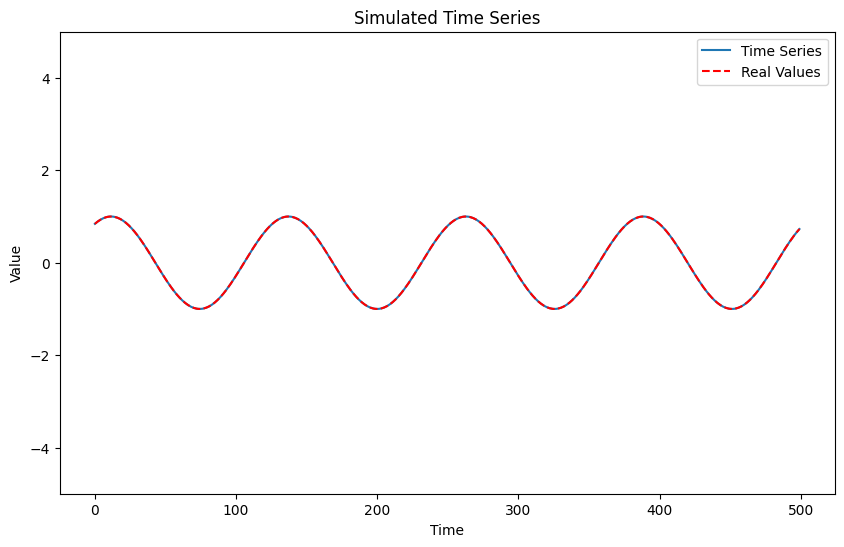

In [2]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}

simul = TimeSeriesSimulator(determ=sinForm,noise=None)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = {
    "mean": "None",
    "std": "None",
    "median": "None",
}

Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [3]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3093 - mae: 0.3093 - mape: 56.9534 - mse: 0.2104    
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0520 - mae: 0.0520 - mape: 14.1788 - mse: 0.0042    
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1048 - mae: 0.1048 - mape: 16.7333 - mse: 0.0193
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0323 - mae: 0.0323 - mape: 7.5953 - mse: 0.0016  
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mae: 0.0217 - mape: 7.6180 - mse: 6.8914e-04  
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0402 - mae: 0.0402 - mape: 9.2447 - mse: 0.0025 
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0365 - mae: 0.0365 - mape: 10.3127 - mse: 0.0021    
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0347 - mae: 0.0347 - mape: 6.2011 - mse: 0.0018 
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0602 - mae: 0.0602 - mape: 12.2022 - mse: 0.0061 
Epoch 10/50

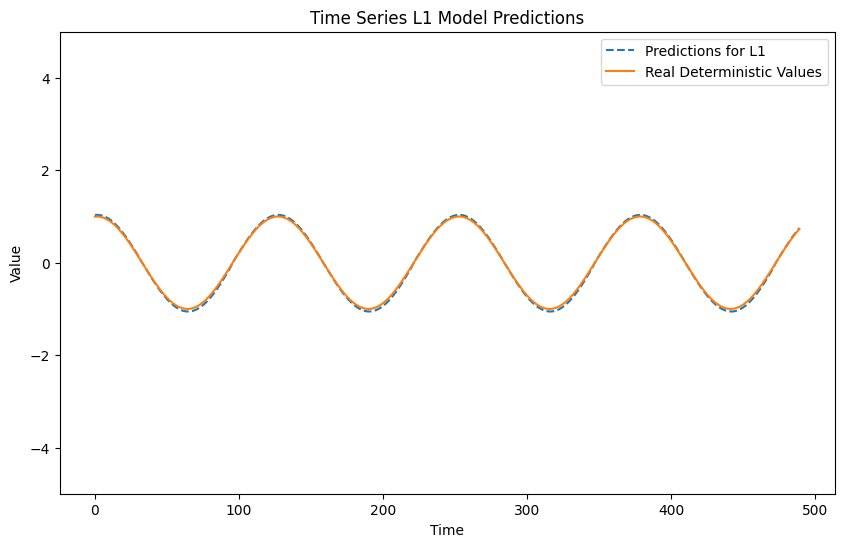

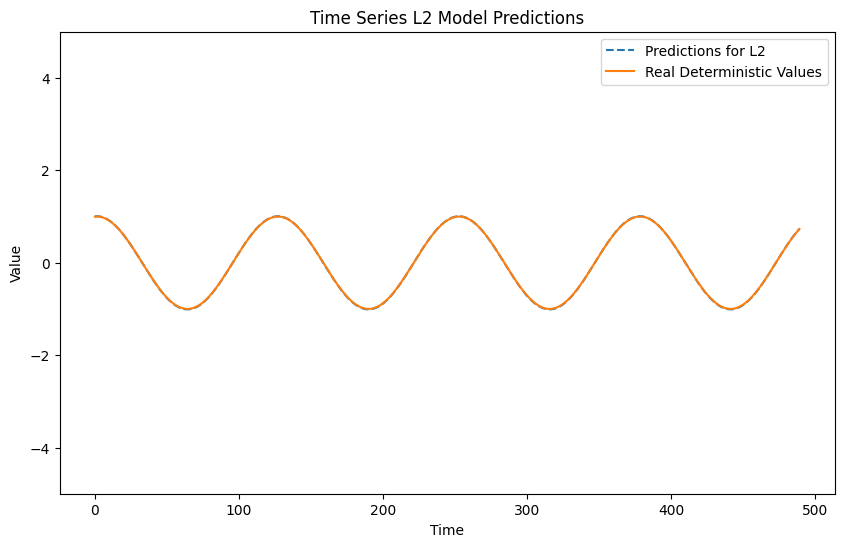

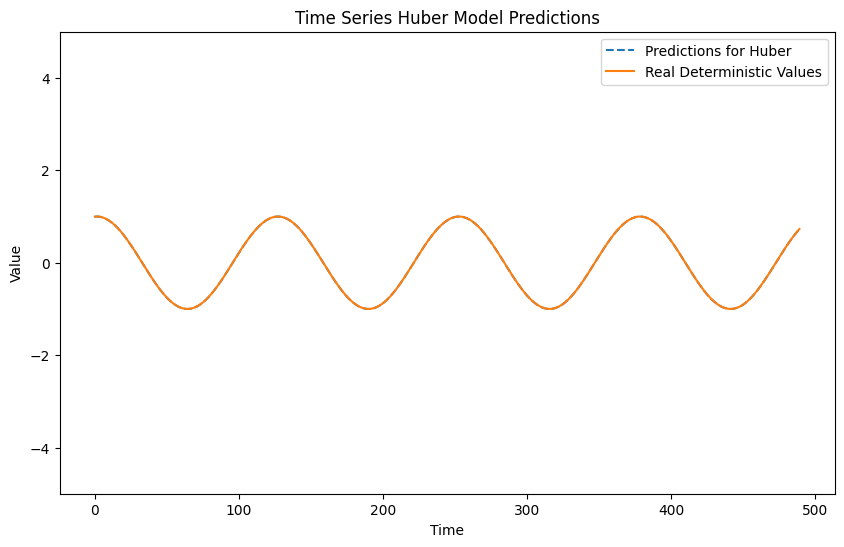

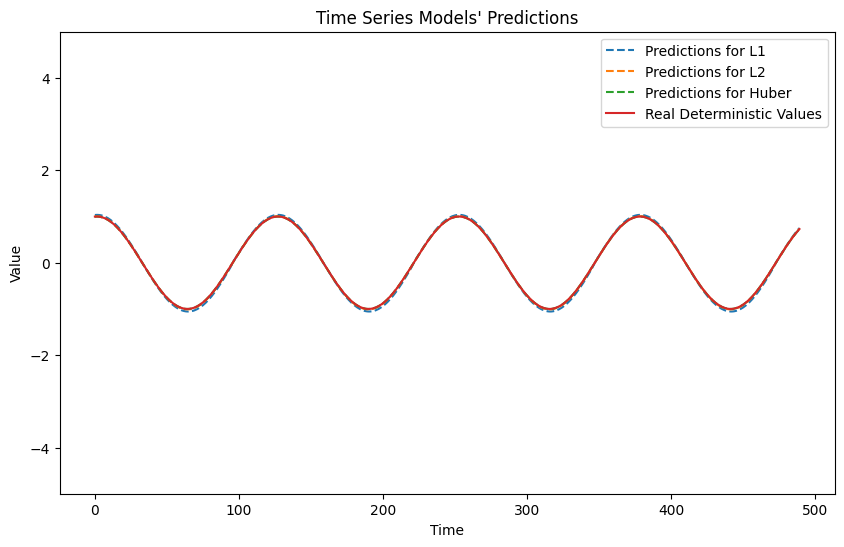

In [4]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: 0.008559496208216043 vs. Theoretical Mean: None
Median: 0.0016626630491656785 vs. Theoretical Median: None
Standard Dev.: 0.03461096484767247 vs. Theoretical Std. Dev.: None
Skew: 0.19717997564168233
Kurtosis: -1.4800775220277709
Max: 0.0611762477185811
Min: -0.03643025157244373




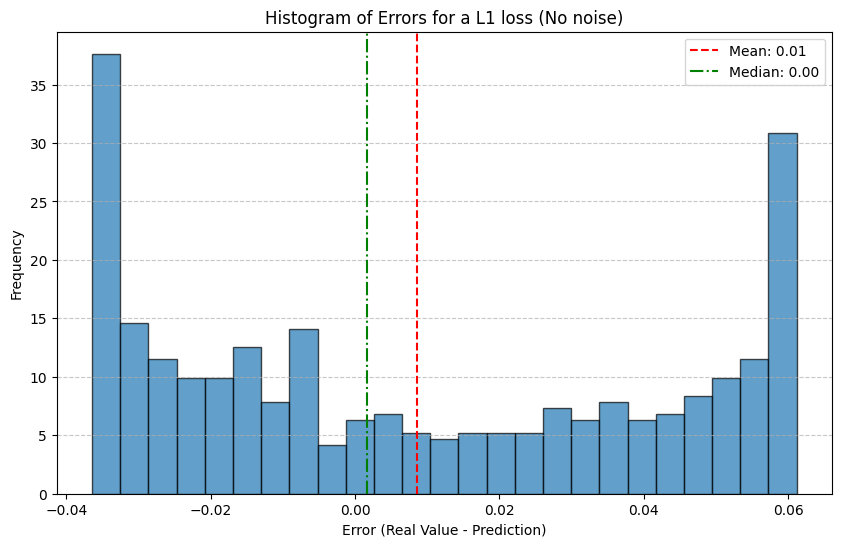

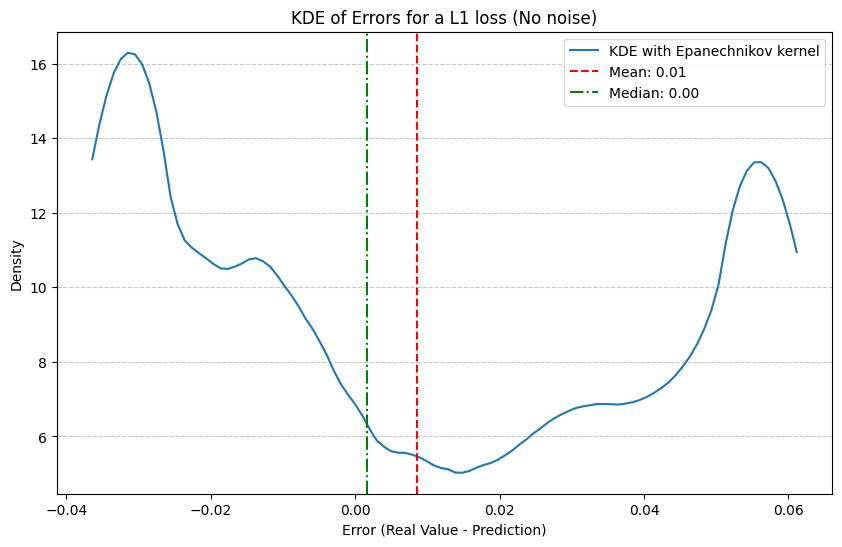

Analyzing errors for L2 loss...

Mean: 0.0018987219245727646 vs. Theoretical Mean: None
Median: 0.0016919841065203096 vs. Theoretical Median: None
Standard Dev.: 0.005178422468365144 vs. Theoretical Std. Dev.: None
Skew: 0.07842251423362048
Kurtosis: -1.425945740802127
Max: 0.009639967764171087
Min: -0.005429526670522322




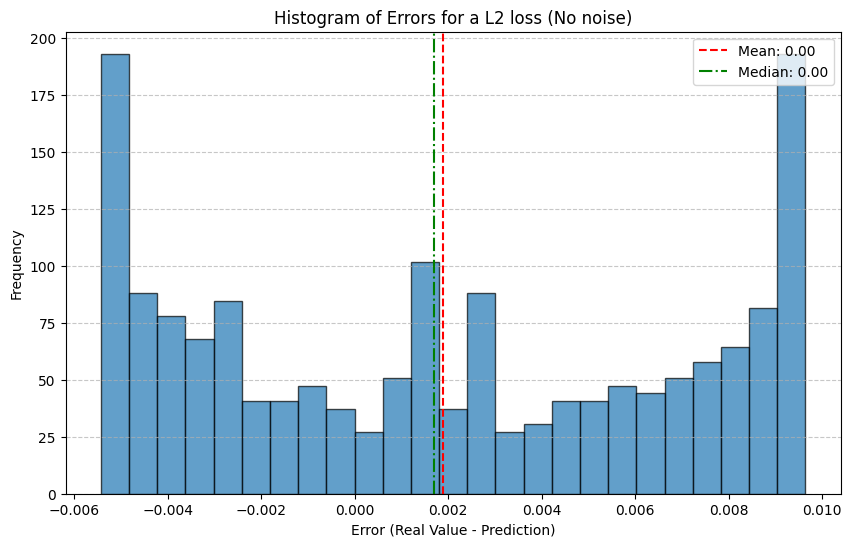

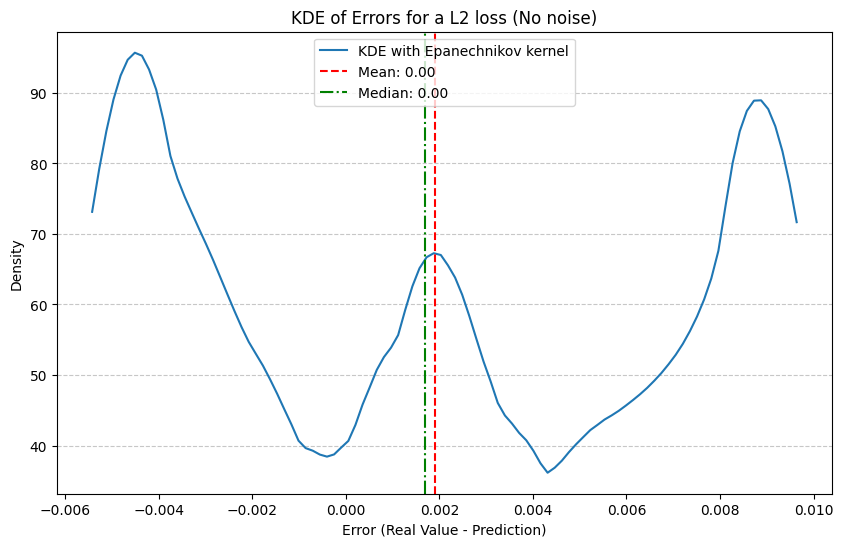

Analyzing errors for Huber loss...

Mean: 0.0008257420645269885 vs. Theoretical Mean: None
Median: 0.000992280479458596 vs. Theoretical Median: None
Standard Dev.: 0.00043850205951135847 vs. Theoretical Std. Dev.: None
Skew: -1.4047831376689721
Kurtosis: 1.8276014424644096
Max: 0.00207519065442896
Min: -0.0012403068968534492




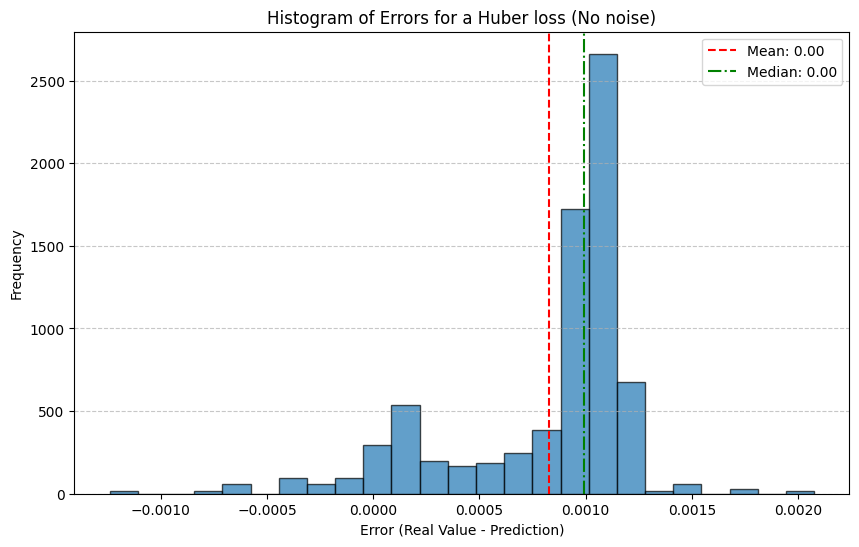

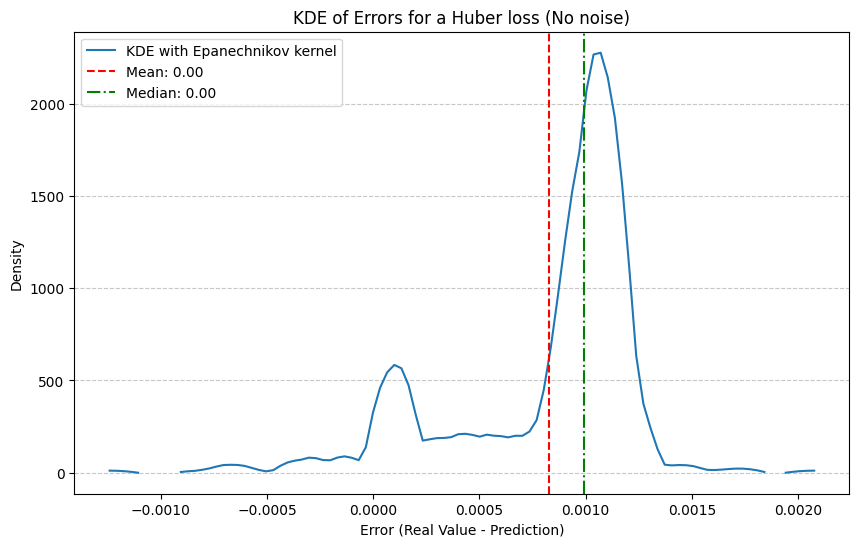

In [5]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=None)
    plot_hist.get_plot(loss_name=loss)

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=None,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss)

**Gaussian Stochastic Process**

We simulate the time series with a Normally-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{N}(0,1)$$

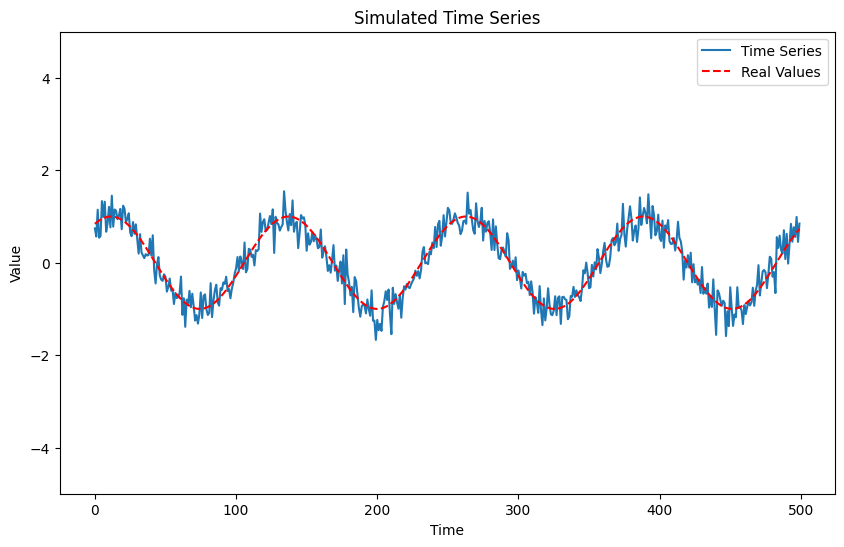

Theoretical Mean: 0
Theoretical Std. Dev.: 0.25
Theoretical Median: 0



In [6]:
n = 500
params = {"A": 1, "B":0.05, "C":1}
norm = NormalDist({"loc": 0, "scale":0.25})

simul = TimeSeriesSimulator(determ=sinForm,noise=norm)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = norm.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [7]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5707 - mae: 0.5707 - mape: 132.5064 - mse: 0.6316   
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3223 - mae: 0.3223 - mape: 352.0834 - mse: 0.1684
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3137 - mae: 0.3137 - mape: 88.8447 - mse: 0.1627 
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3294 - mae: 0.3294 - mape: 190.3192 - mse: 0.1729
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3117 - mae: 0.3117 - mape: 191.8198 - mse: 0.1616
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2903 - mae: 0.2903 - mape: 593.5130 - mse: 0.1435  
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3056 - mae: 0.3056 - mape: 191.7363 - mse: 0.1628
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2869 - mae: 0.2869 - mape: 203.0192 - mse: 0.1350
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3005 - mae: 0.3005 - mape: 342.7162 - mse: 0.1405
Epoch 10/50
31/3

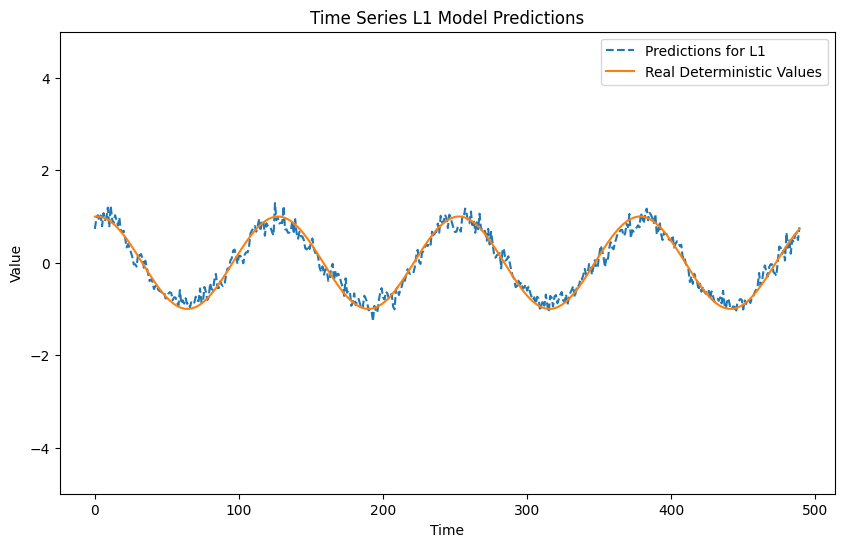

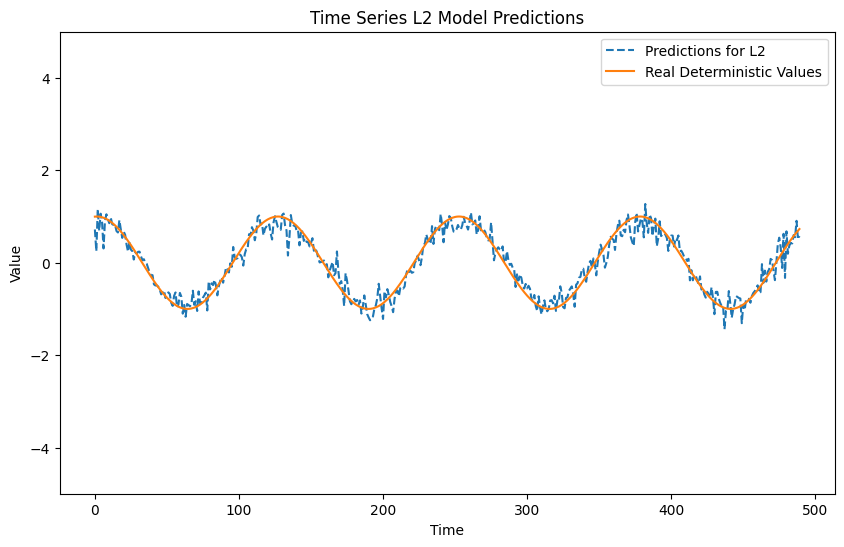

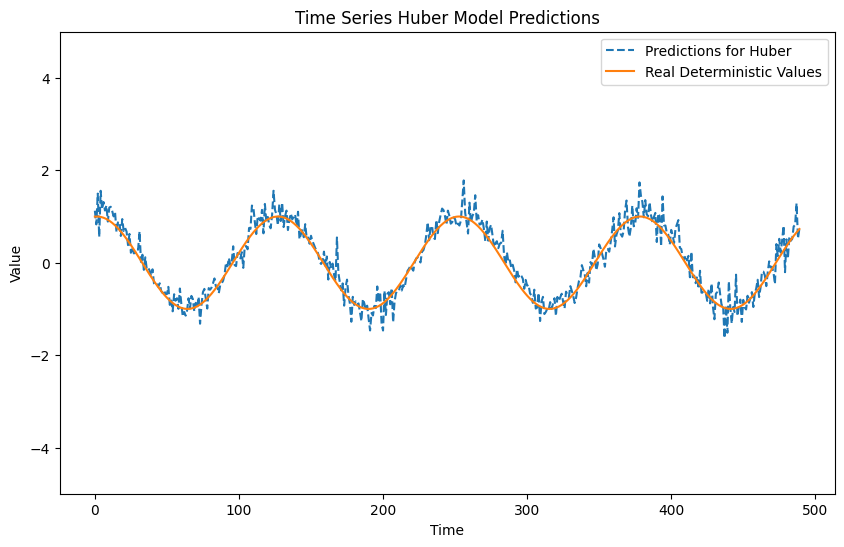

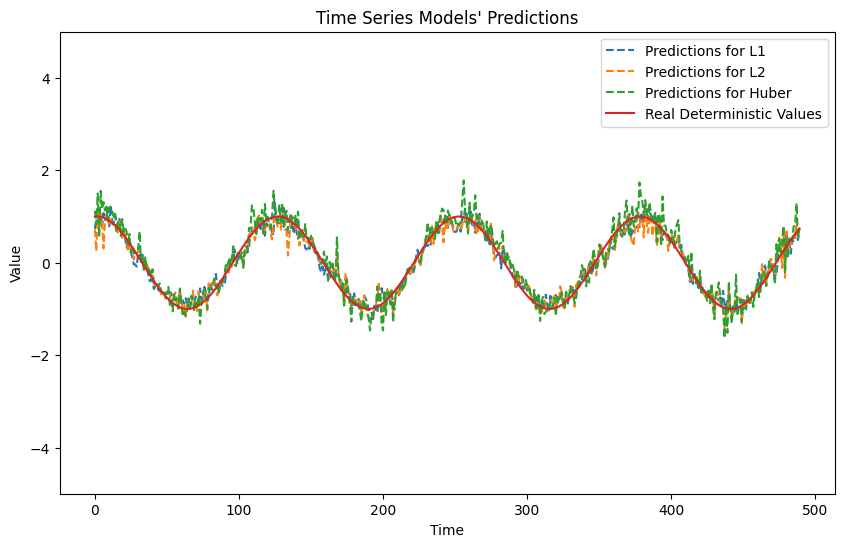

In [8]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: -0.009956965478379971 vs. Theoretical Mean: 0
Median: -0.011291148389567157 vs. Theoretical Median: 0
Standard Dev.: 0.2700859245605637 vs. Theoretical Std. Dev.: 0.25
Skew: 0.054066205902410965
Kurtosis: 0.7292911388980632
Max: 0.9545481794787509
Min: -0.8049644981377371




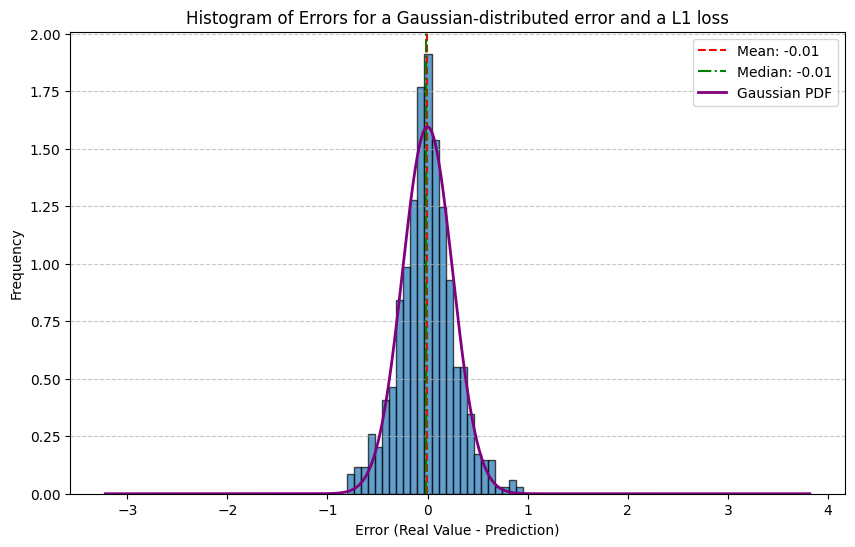

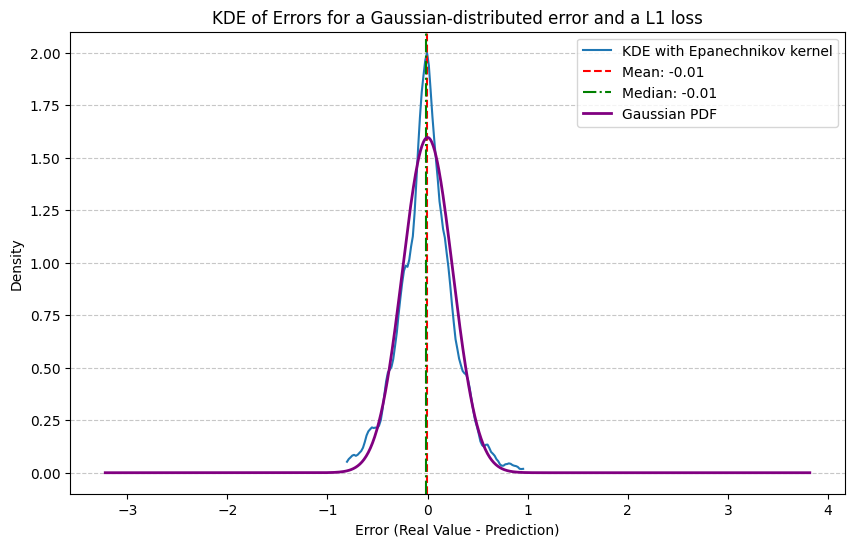

Analyzing errors for L2 loss...

Mean: -0.003731017052077678 vs. Theoretical Mean: 0
Median: -0.008399829496598427 vs. Theoretical Median: 0
Standard Dev.: 0.21056945876442634 vs. Theoretical Std. Dev.: 0.25
Skew: 0.10131761398601258
Kurtosis: 0.5417251054632222
Max: 0.7980588460539657
Min: -0.6683177008999636




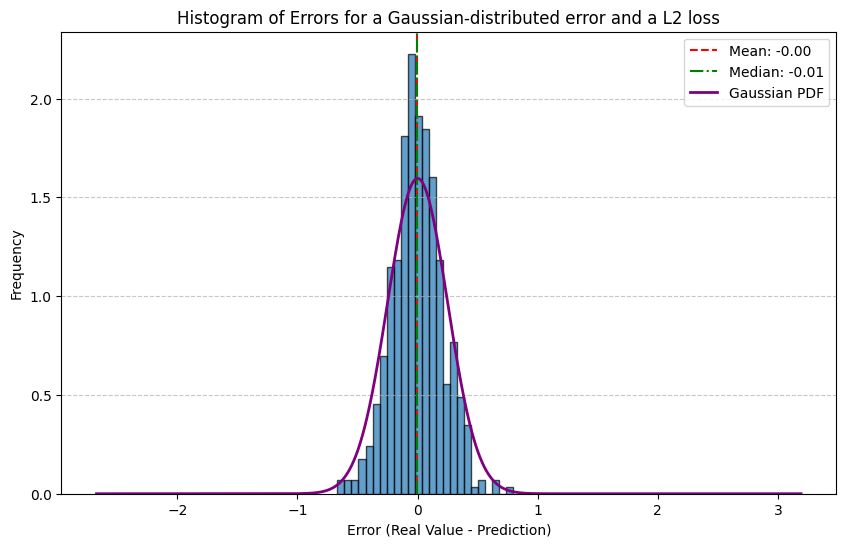

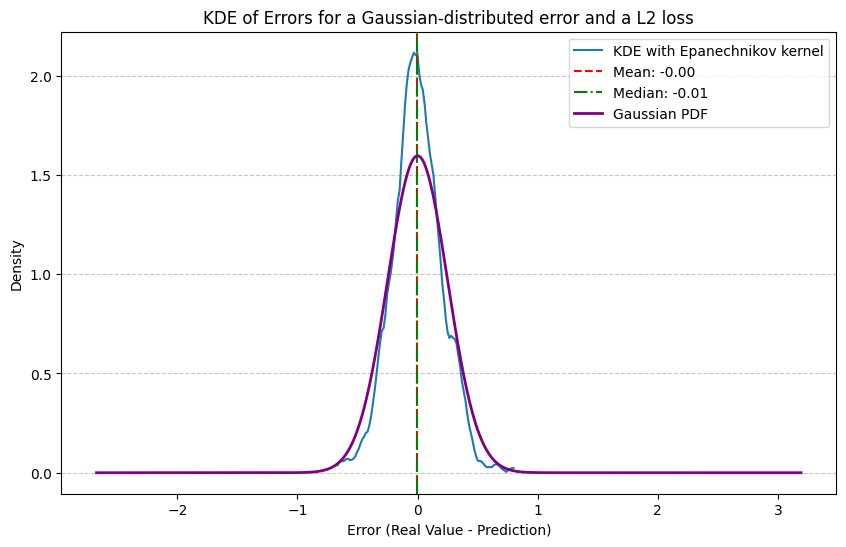

Analyzing errors for Huber loss...

Mean: -0.07172386562905554 vs. Theoretical Mean: 0
Median: -0.06452395338295713 vs. Theoretical Median: 0
Standard Dev.: 0.1754235291303071 vs. Theoretical Std. Dev.: 0.25
Skew: -0.5437291139409574
Kurtosis: 1.608362871066463
Max: 0.6122208619688827
Min: -0.7404791270249136




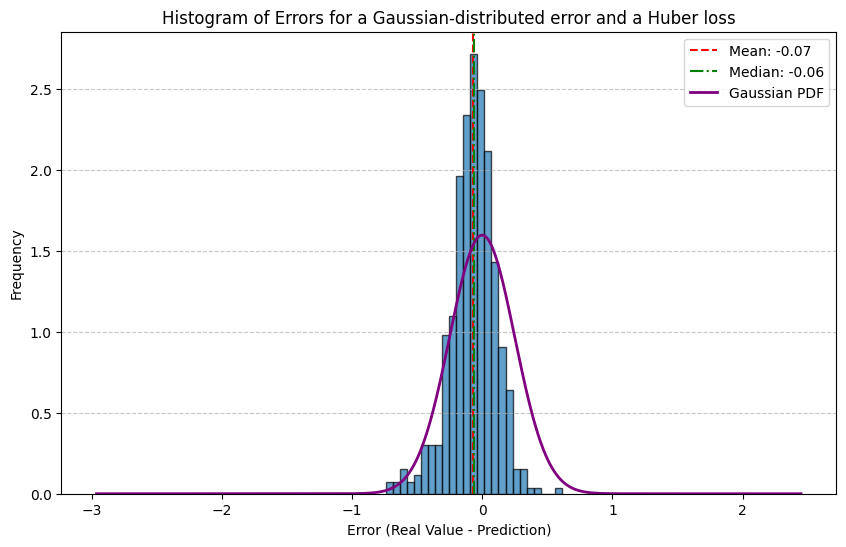

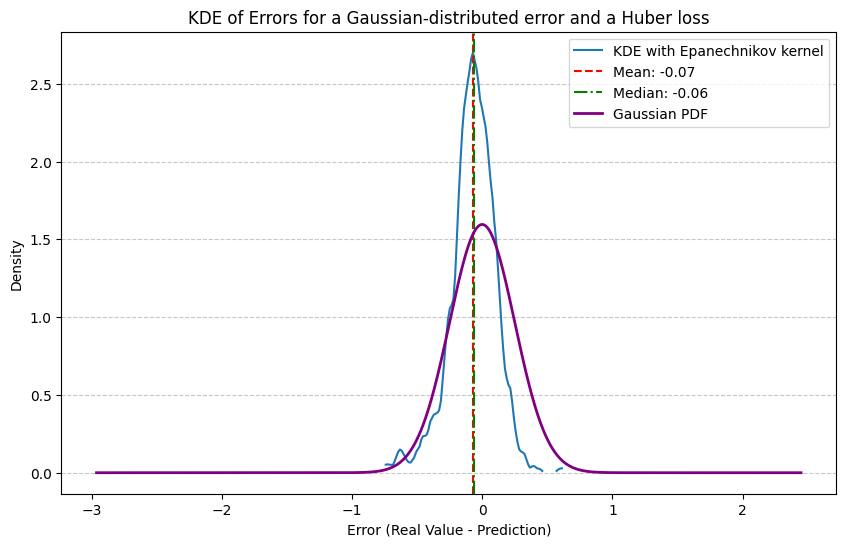

In [9]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=norm)
    plot_hist.get_plot(loss_name=loss)

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=norm,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss)

**Cauchy Stochastic Process**

We simulate the time series with a Cauchy-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Cauchy}(0,1)$$

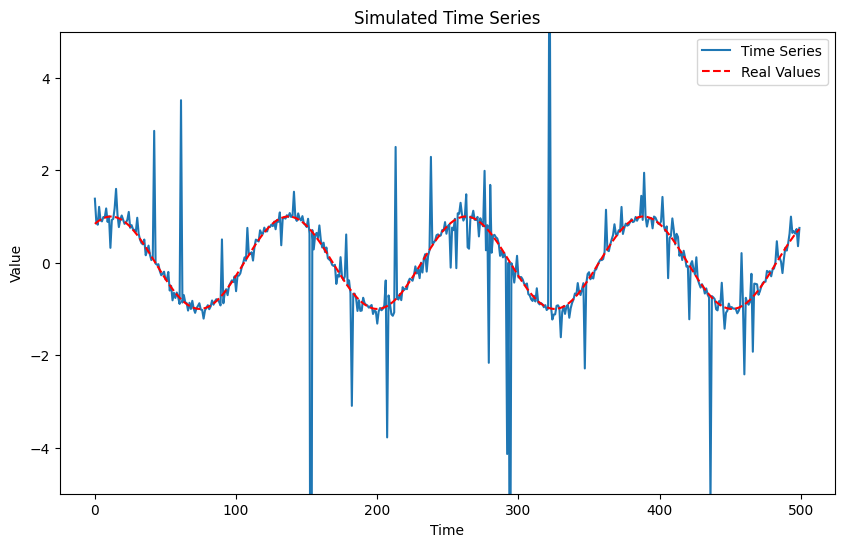

Theoretical Mean: None (Undefined)
Theoretical Std. Dev.: None (Undefined)
Theoretical Median: 0



In [10]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
cauchy = CauchyDist({"loc": 0, "scale":0.05})

simul = TimeSeriesSimulator(determ=sinForm,noise=cauchy)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = cauchy.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [11]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5121 - mae: 0.5121 - mape: 268.1429 - mse: 1.1397   
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3704 - mae: 0.3704 - mape: 139.7200 - mse: 1.0401 
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3269 - mae: 0.3269 - mape: 140.6360 - mse: 0.6572 
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2756 - mae: 0.2756 - mape: 103.9138 - mse: 0.6870
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4303 - mae: 0.4303 - mape: 167.5733 - mse: 1.8913  
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3209 - mae: 0.3209 - mape: 90.2863 - mse: 0.9720 
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3387 - mae: 0.3387 - mape: 110.5893 - mse: 0.7877
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3139 - mae: 0.3139 - mape: 89.7989 - mse: 0.9027 
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2804 - mae: 0.2804 - mape: 100.9089 - mse: 0.7839 
Epoch 10/50
3

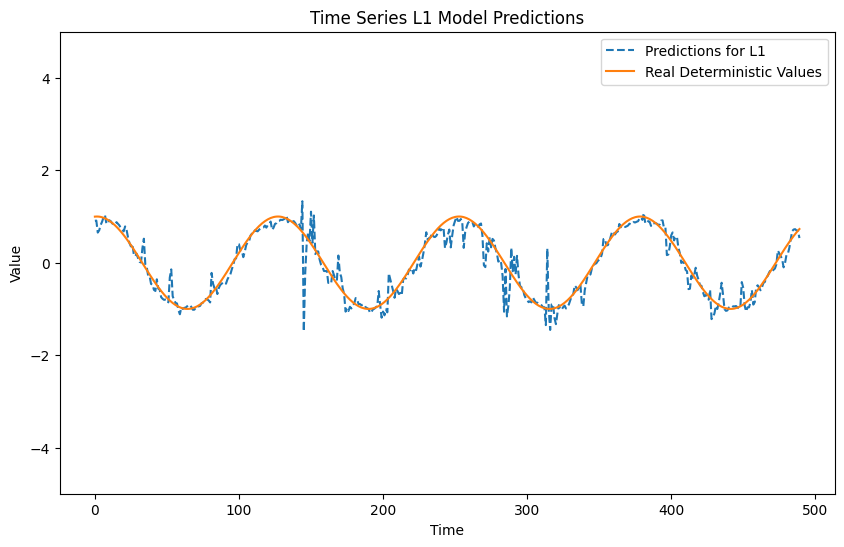

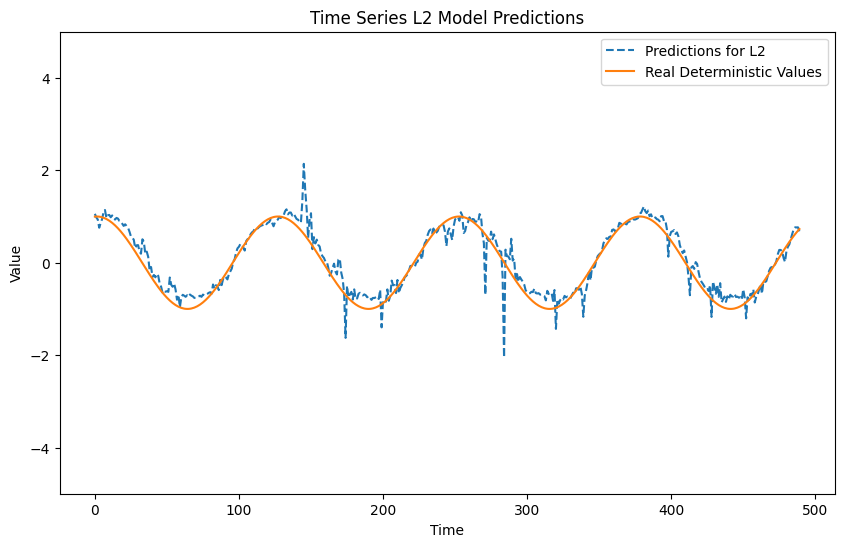

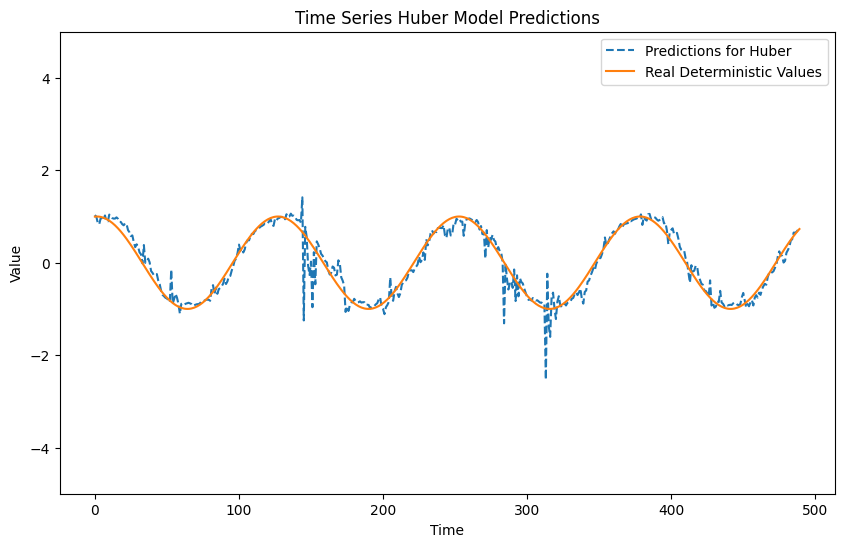

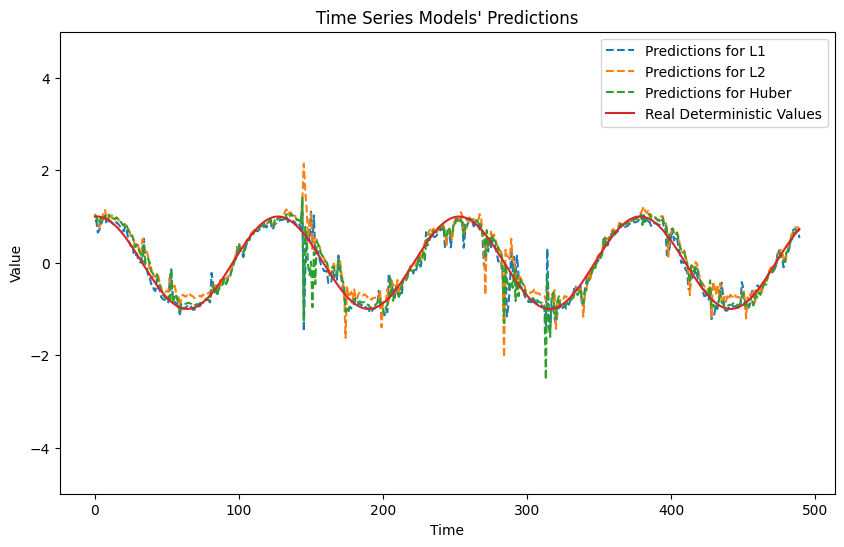

In [12]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: -0.007775811986139154 vs. Theoretical Mean: 0.5833333333333334
Median: -0.06091583133262729 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.31063385074653327 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.960346650151615
Kurtosis: 47.64387074752197
Max: 3.7784762786288546
Min: -0.5887157792345002




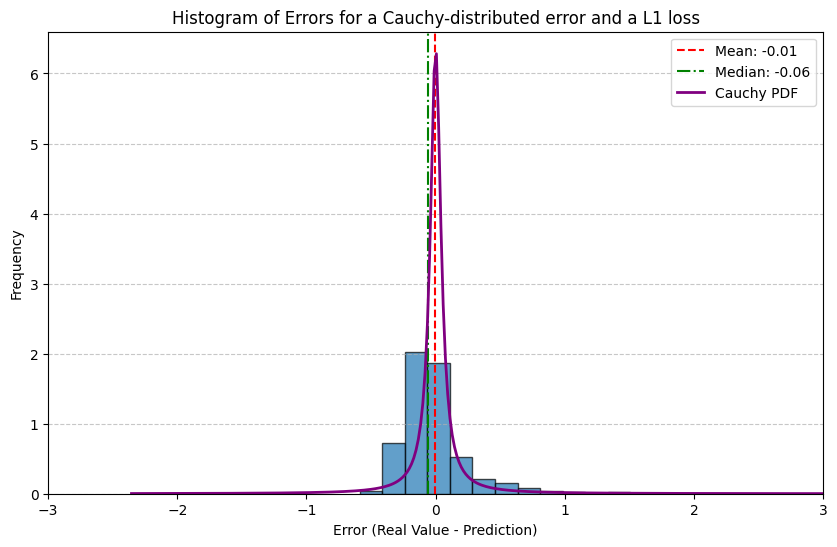

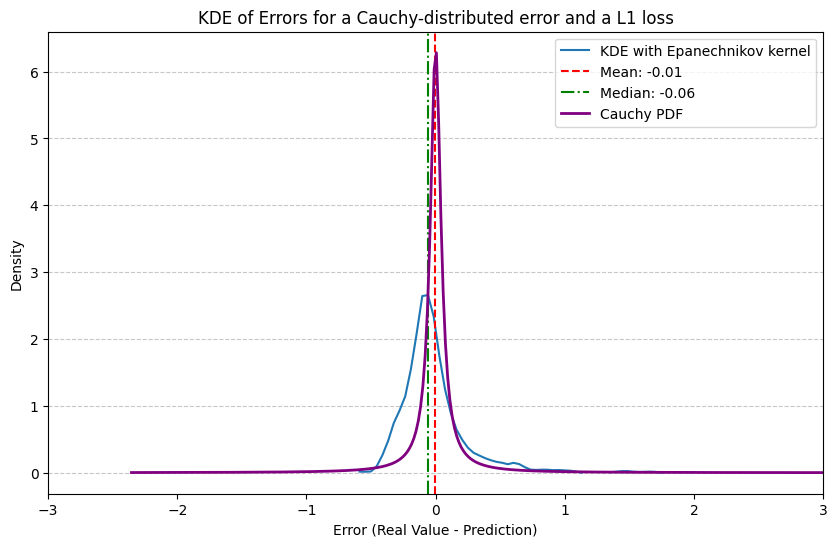

Analyzing errors for L2 loss...

Mean: 0.04521517847464938 vs. Theoretical Mean: 0.5833333333333334
Median: 0.001568952769305132 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29358311141585897 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.816344746254932
Kurtosis: 47.97251488130122
Max: 3.6464586065669344
Min: -0.47321993673254903




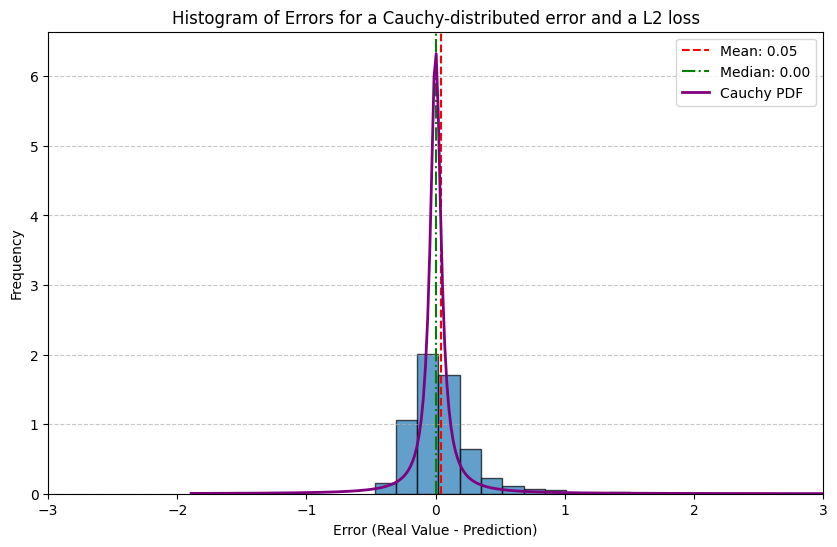

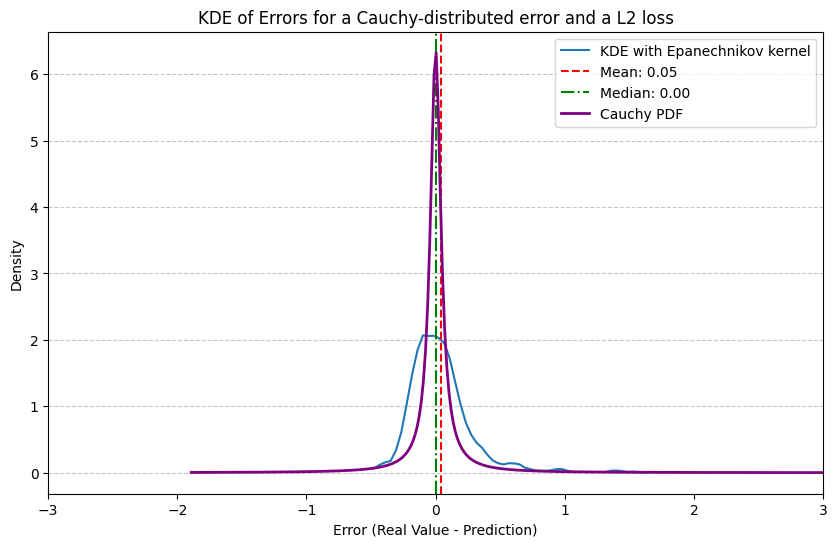

Analyzing errors for Huber loss...

Mean: -0.0002705575673076472 vs. Theoretical Mean: 0.5833333333333334
Median: -0.04720144722726527 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29400740650602464 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 5.286491832810582
Kurtosis: 54.213606519450785
Max: 3.716191868629007
Min: -0.49443336074504407




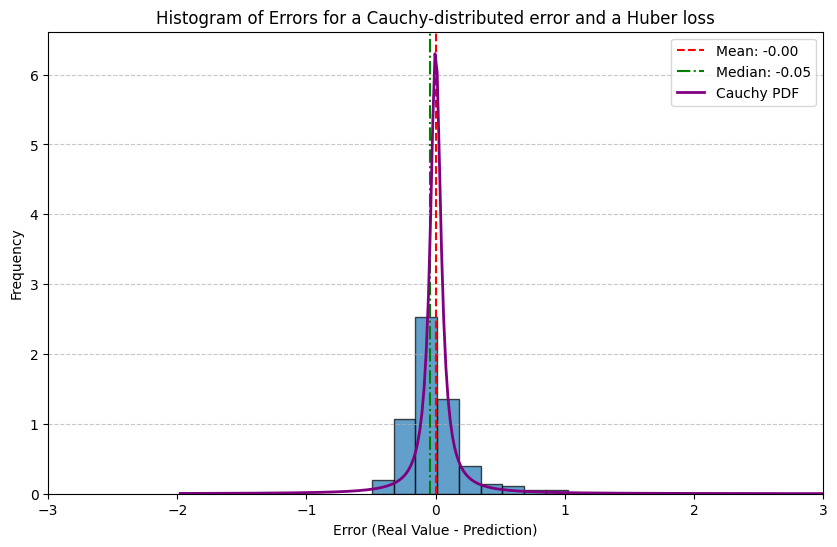

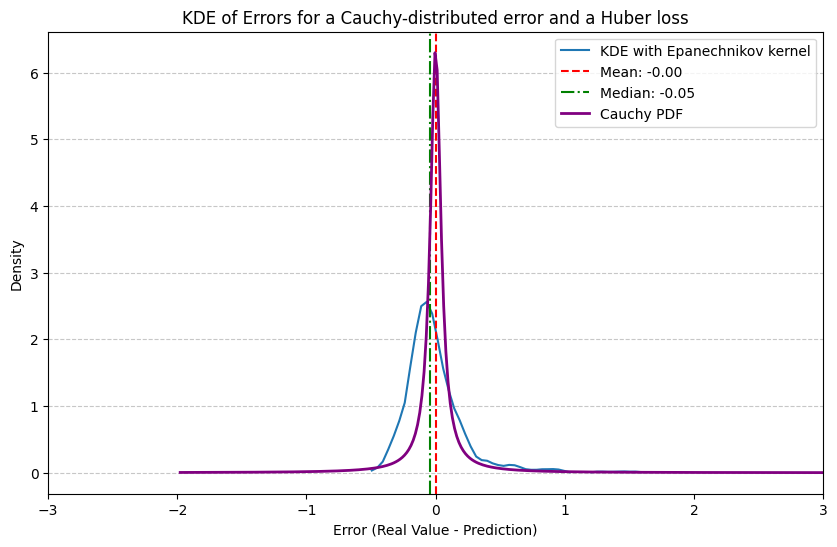

In [27]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=cauchy)
    plot_hist.get_plot(loss_name=loss,x_limits=[-3,3])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=cauchy,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-3,3])

**Gumbel Stochastic Process**

We simulate the time series with a Gumbel-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Gumbel}(1.5,3.5)$$

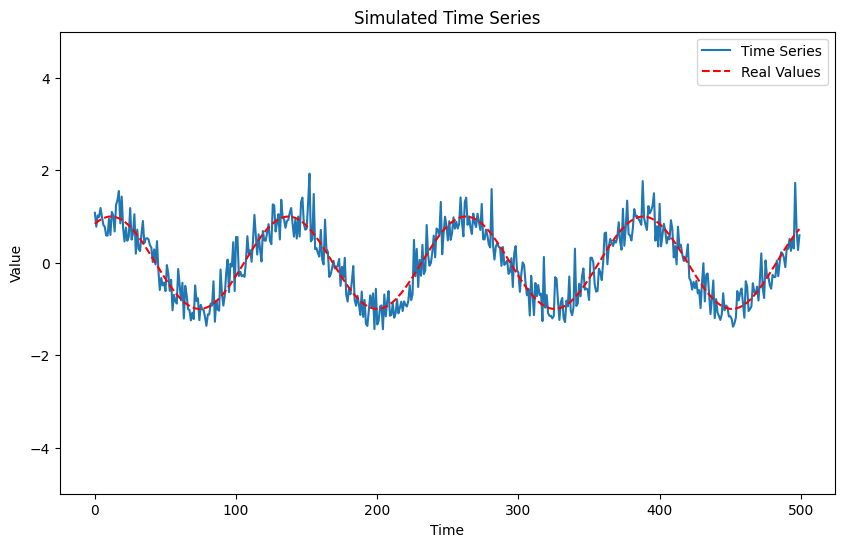

Theoretical Mean: 3.1443039162253834
Theoretical Std. Dev.: 0.320637457540466
Theoretical Median: 3.091628230145416



In [14]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
gumbel = GumbelDist({"loc": 3, "scale":0.25}, demean=True)

simul = TimeSeriesSimulator(determ=sinForm, noise=gumbel)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = gumbel.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [15]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5327 - mae: 0.5327 - mape: 141.3846 - mse: 0.4916   
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3854 - mae: 0.3854 - mape: 99.9135 - mse: 0.2384 
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4450 - mae: 0.4450 - mape: 310.3526 - mse: 0.3192 
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4245 - mae: 0.4245 - mape: 171.5325 - mse: 0.2866
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3720 - mae: 0.3720 - mape: 139.7212 - mse: 0.2386 
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3524 - mae: 0.3524 - mape: 186.0775 - mse: 0.2081
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3737 - mae: 0.3737 - mape: 129.8034 - mse: 0.2344 
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3356 - mae: 0.3356 - mape: 219.1151 - mse: 0.1958  
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3599 - mae: 0.3599 - mape: 127.7575 - mse: 0.2192 
Epoch 10/50


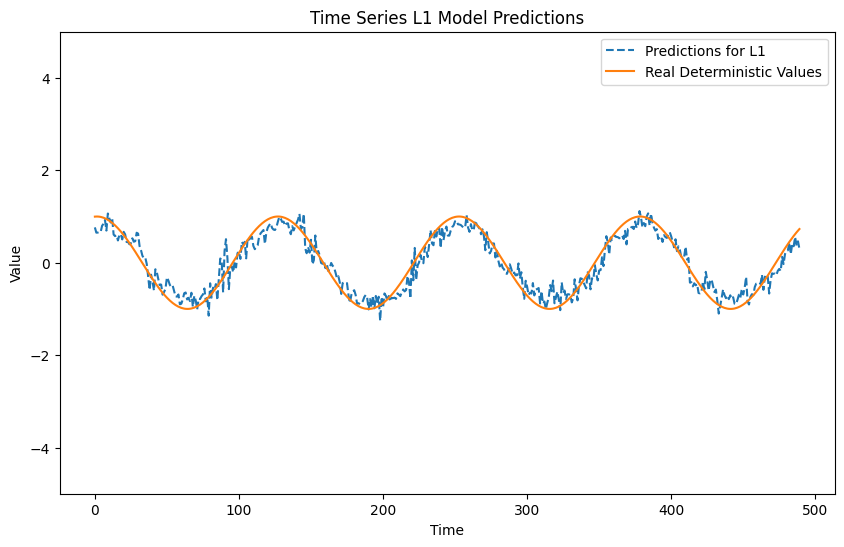

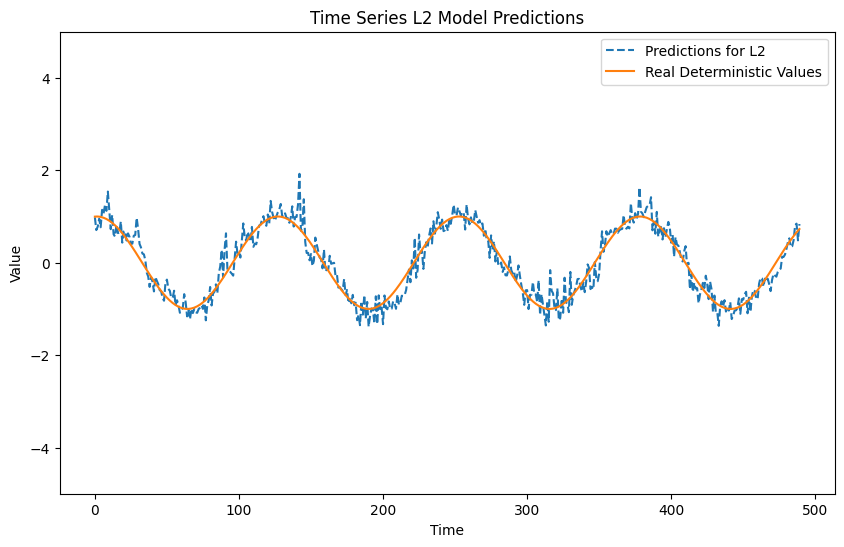

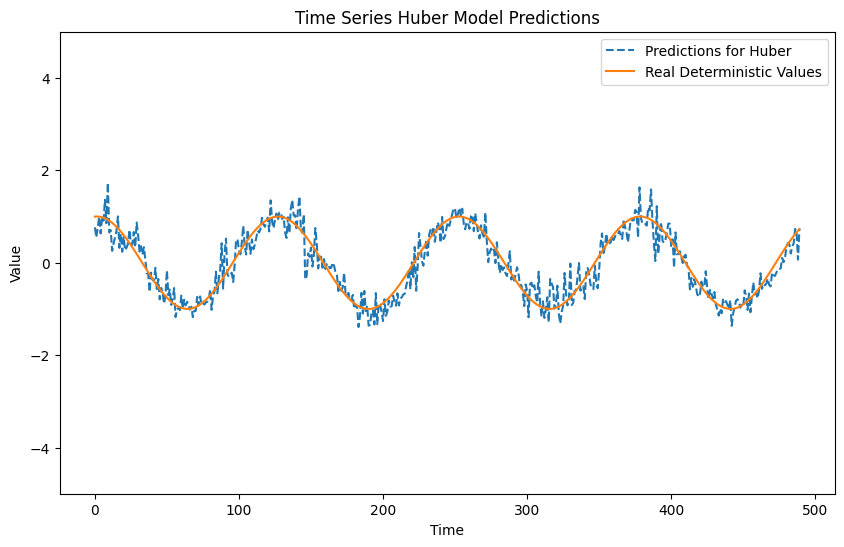

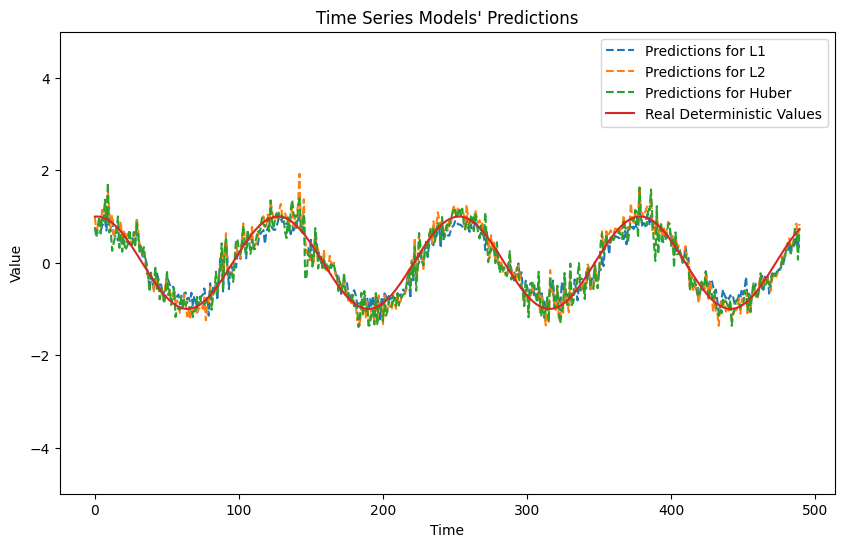

In [16]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: -0.007775811986139154 vs. Theoretical Mean: 0.5833333333333334
Median: -0.06091583133262729 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.31063385074653327 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.960346650151615
Kurtosis: 47.64387074752197
Max: 3.7784762786288546
Min: -0.5887157792345002




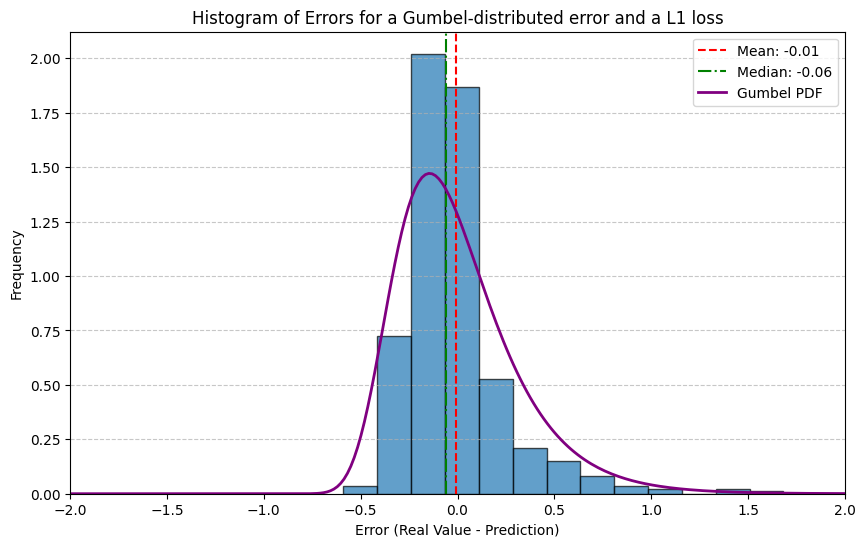

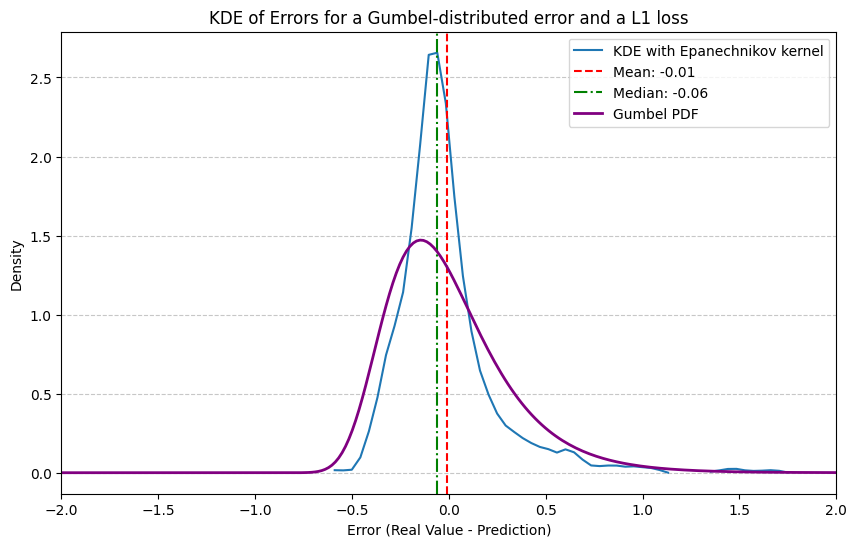

Analyzing errors for L2 loss...

Mean: 0.04521517847464938 vs. Theoretical Mean: 0.5833333333333334
Median: 0.001568952769305132 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29358311141585897 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.816344746254932
Kurtosis: 47.97251488130122
Max: 3.6464586065669344
Min: -0.47321993673254903




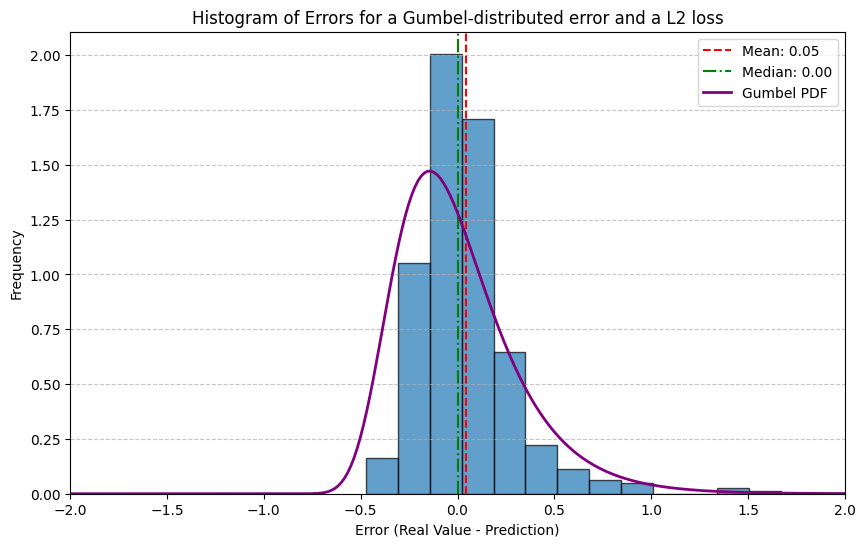

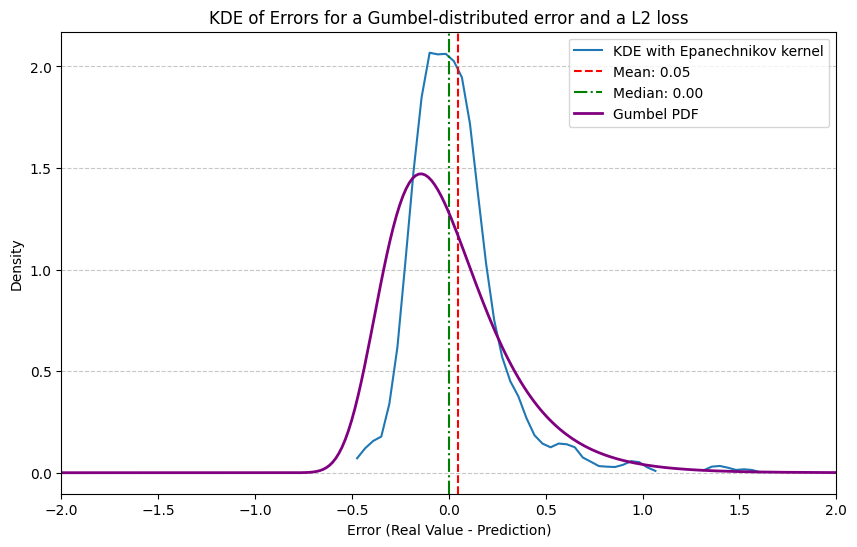

Analyzing errors for Huber loss...

Mean: -0.0002705575673076472 vs. Theoretical Mean: 0.5833333333333334
Median: -0.04720144722726527 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29400740650602464 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 5.286491832810582
Kurtosis: 54.213606519450785
Max: 3.716191868629007
Min: -0.49443336074504407




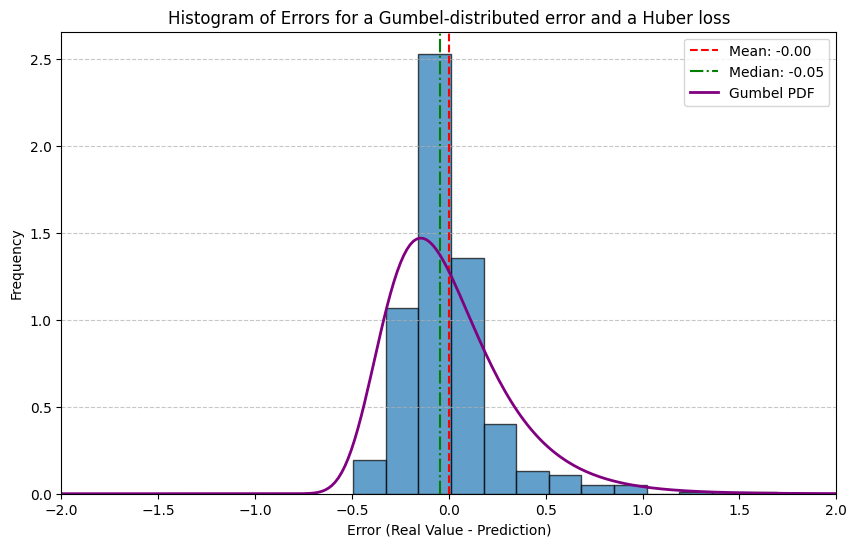

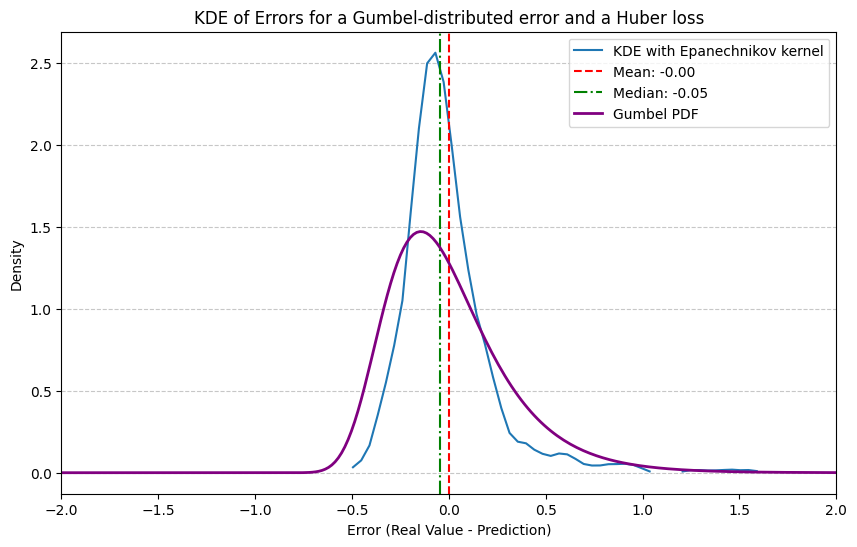

In [28]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=gumbel)
    plot_hist.get_plot(loss_name=loss,x_limits=[-2,2])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=gumbel,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-2,2])

**Log-Normal Stochastic Process**

We simulate the time series with a Lognormal-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{logN}(-2.5,1)$$

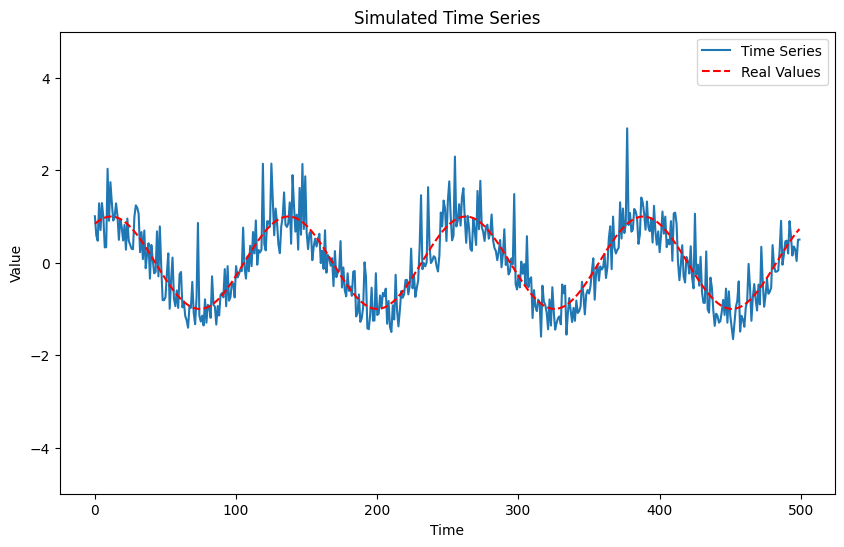

Theoretical Mean: 1.0832870676749586
Theoretical Std. Dev.: 0.4512392861267145
Theoretical Median: 1.0



In [18]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
lognorm = LogNormalDist({"mean": 0, "sigma": 0.4},demean=True)

simul = TimeSeriesSimulator(determ=sinForm,noise=lognorm)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = lognorm.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [19]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6010 - mae: 0.6010 - mape: 265.8760 - mse: 0.6351   
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4682 - mae: 0.4682 - mape: 179.1151 - mse: 0.3786 
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4405 - mae: 0.4405 - mape: 356.9628 - mse: 0.3346
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4651 - mae: 0.4651 - mape: 140.0090 - mse: 0.3902 
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4087 - mae: 0.4087 - mape: 217.8847 - mse: 0.3002 
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4223 - mae: 0.4223 - mape: 163.2571 - mse: 0.3377
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4236 - mae: 0.4236 - mape: 297.7698 - mse: 0.3246  
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4096 - mae: 0.4096 - mape: 233.5007 - mse: 0.3076
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4618 - mae: 0.4618 - mape: 171.7633 - mse: 0.4172 
Epoch 10/50


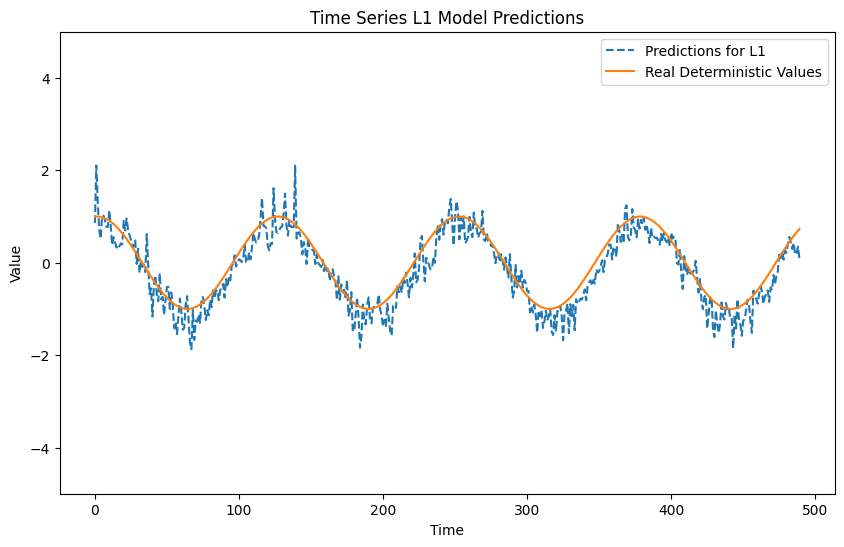

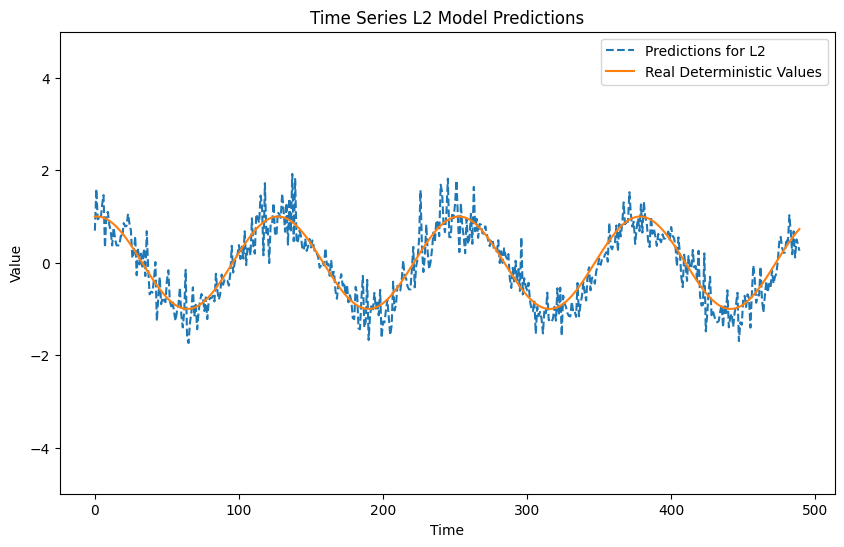

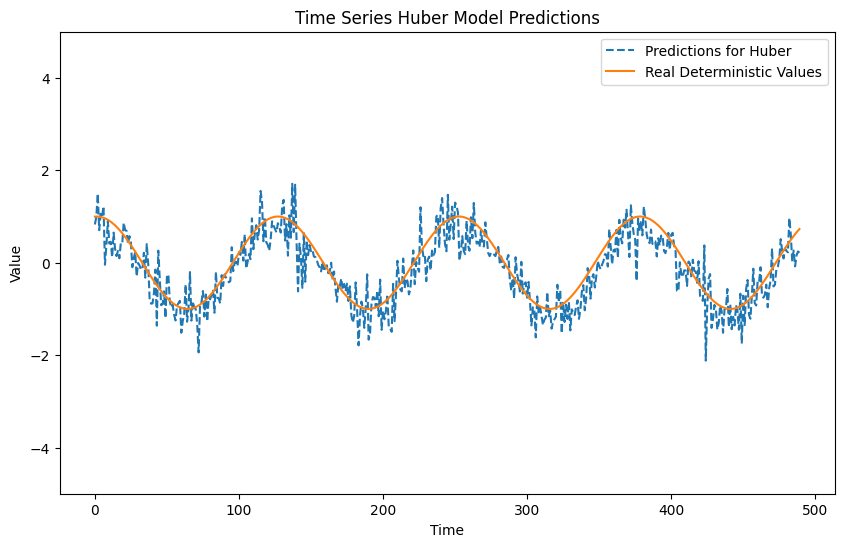

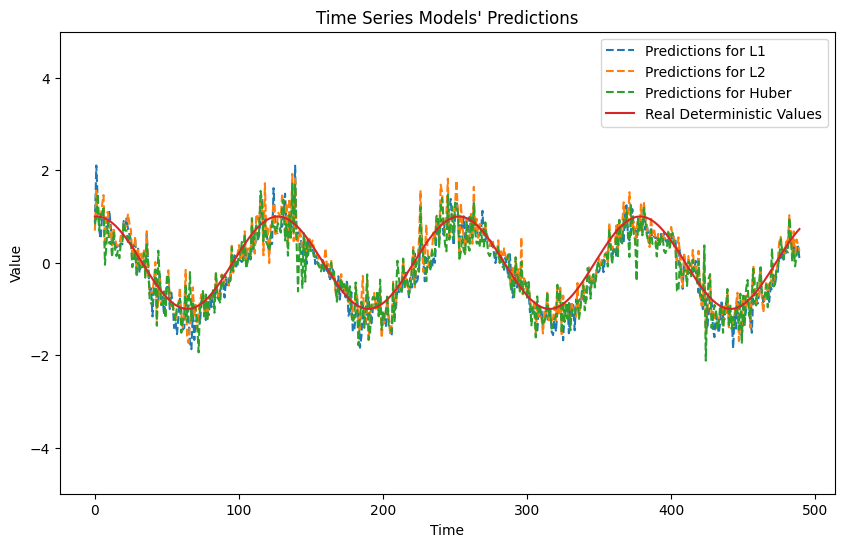

In [20]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: -0.007775811986139154 vs. Theoretical Mean: 0.5833333333333334
Median: -0.06091583133262729 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.31063385074653327 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.960346650151615
Kurtosis: 47.64387074752197
Max: 3.7784762786288546
Min: -0.5887157792345002




c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\src\Probability\classes.py:196: RuntimeWarning: invalid value encountered in log
  (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mean) ** 2) / (2 * sigma ** 2)),


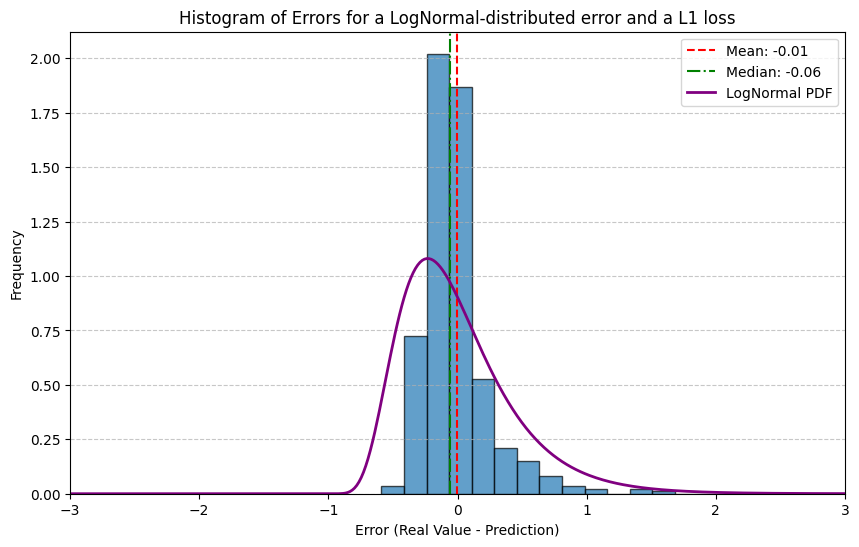

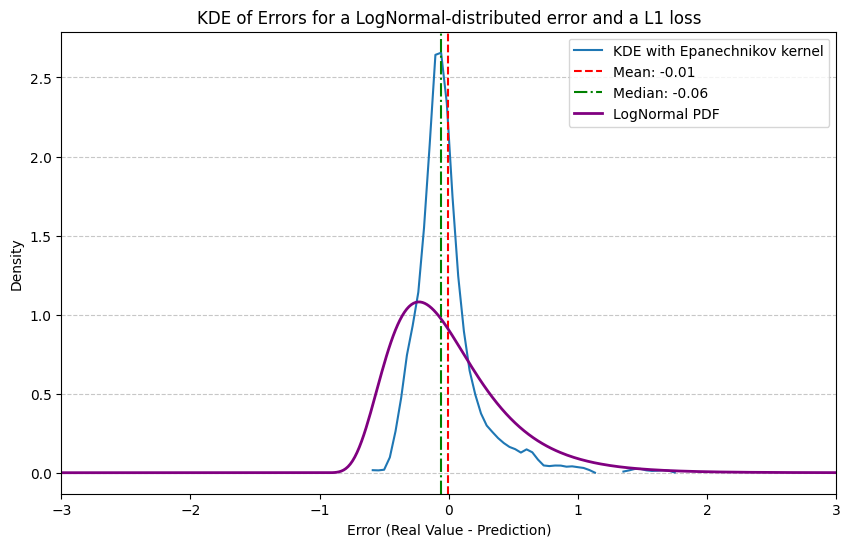

Analyzing errors for L2 loss...

Mean: 0.04521517847464938 vs. Theoretical Mean: 0.5833333333333334
Median: 0.001568952769305132 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29358311141585897 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.816344746254932
Kurtosis: 47.97251488130122
Max: 3.6464586065669344
Min: -0.47321993673254903




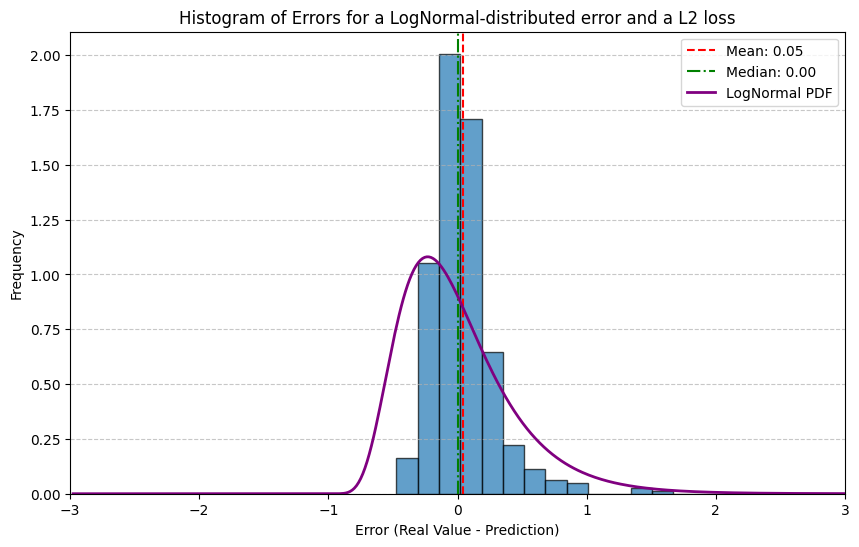

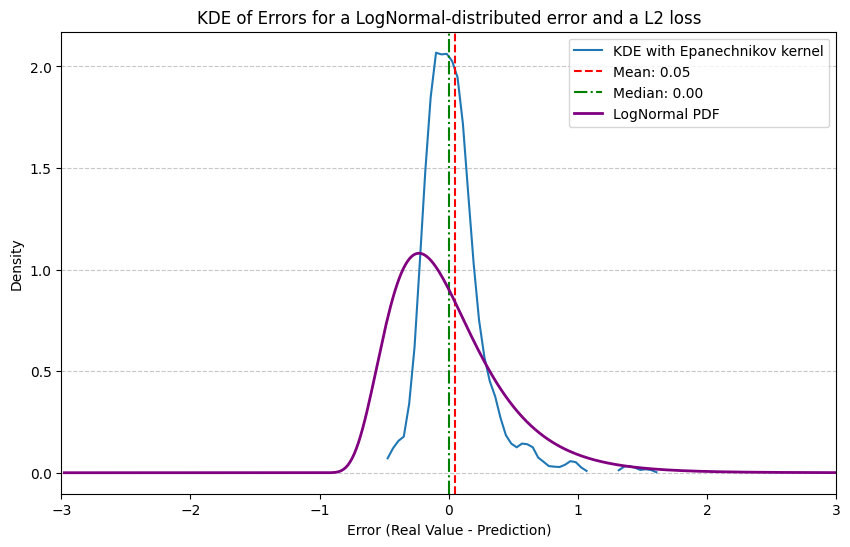

Analyzing errors for Huber loss...

Mean: -0.0002705575673076472 vs. Theoretical Mean: 0.5833333333333334
Median: -0.04720144722726527 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29400740650602464 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 5.286491832810582
Kurtosis: 54.213606519450785
Max: 3.716191868629007
Min: -0.49443336074504407




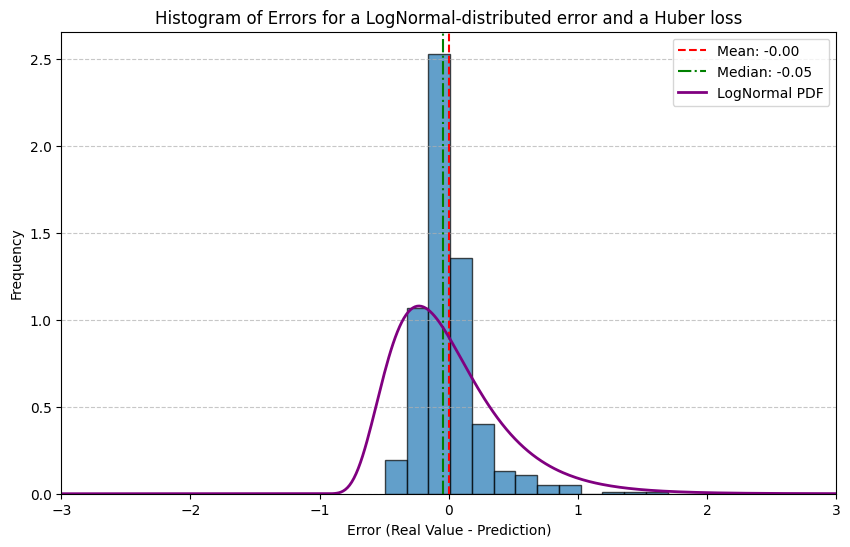

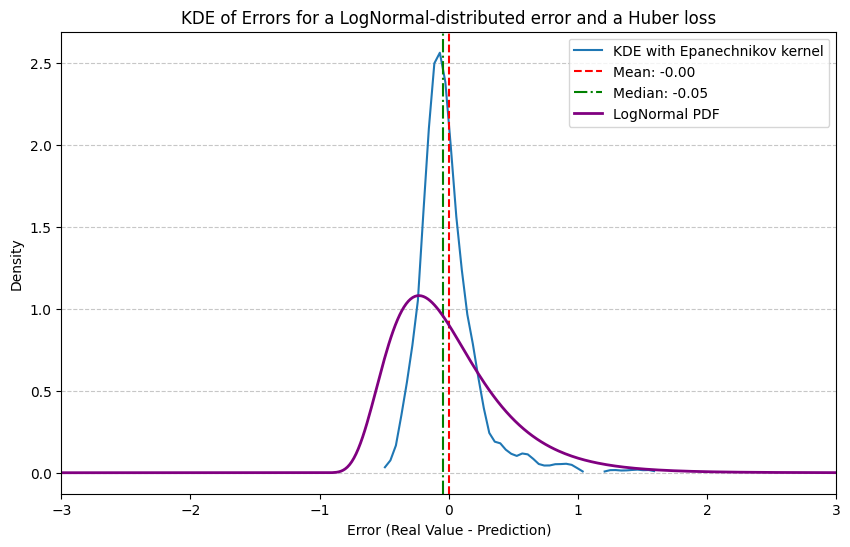

In [29]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=lognorm)
    plot_hist.get_plot(loss_name=loss,x_limits=[-3,3])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=lognorm,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-3,3])

**Pareto Stochastic Process**

We simulate the time series with a Pareto-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Pa}(1,3)$$

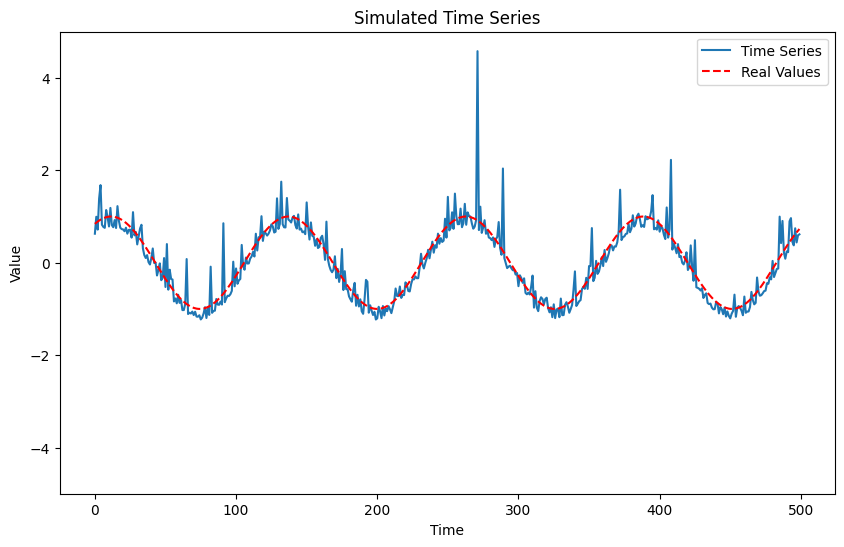

Theoretical Mean: 0.5833333333333334
Theoretical Std. Dev.: 0.5217491947499509
Theoretical Median: 0.46182776877051296



In [22]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
pareto = ParetoDist({"xm": 0.35, "alpha":2.5},demean=True)

simul = TimeSeriesSimulator(determ=sinForm,noise=pareto)
series = simul.simulate(det_params=params, n=500)
simul.plot_sim(scatter_plot=False)

theory = pareto.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [23]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4677 - mae: 0.4677 - mape: 132.8735 - mse: 0.3887   
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2835 - mae: 0.2835 - mape: 113.1135 - mse: 0.1864 
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2568 - mae: 0.2568 - mape: 64.2335 - mse: 0.1513 
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2931 - mae: 0.2931 - mape: 132.4136 - mse: 0.1824 
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2502 - mae: 0.2502 - mape: 73.6682 - mse: 0.1456 
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2432 - mae: 0.2432 - mape: 68.8356 - mse: 0.1400 
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2774 - mae: 0.2774 - mape: 64.2112 - mse: 0.2826 
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2473 - mae: 0.2473 - mape: 67.4506 - mse: 0.1408 
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2469 - mae: 0.2469 - mape: 70.0112 - mse: 0.1807  
Epoch 10/50
31/

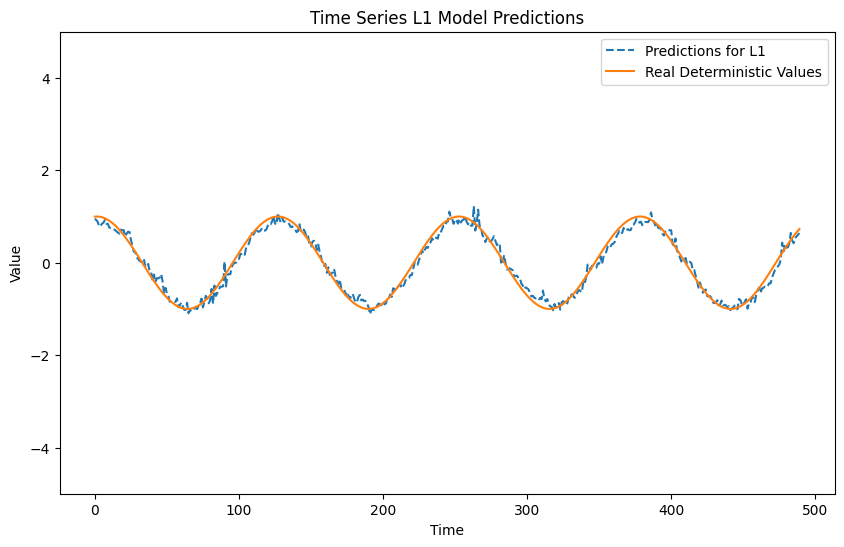

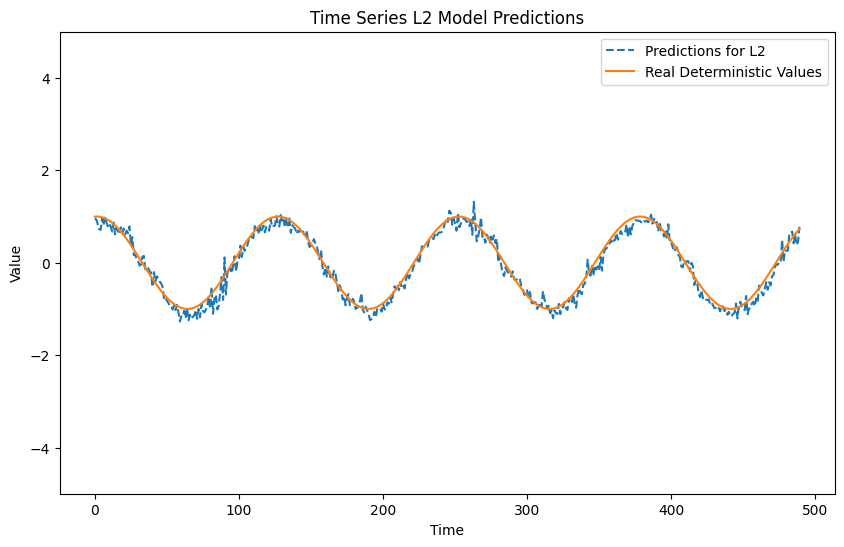

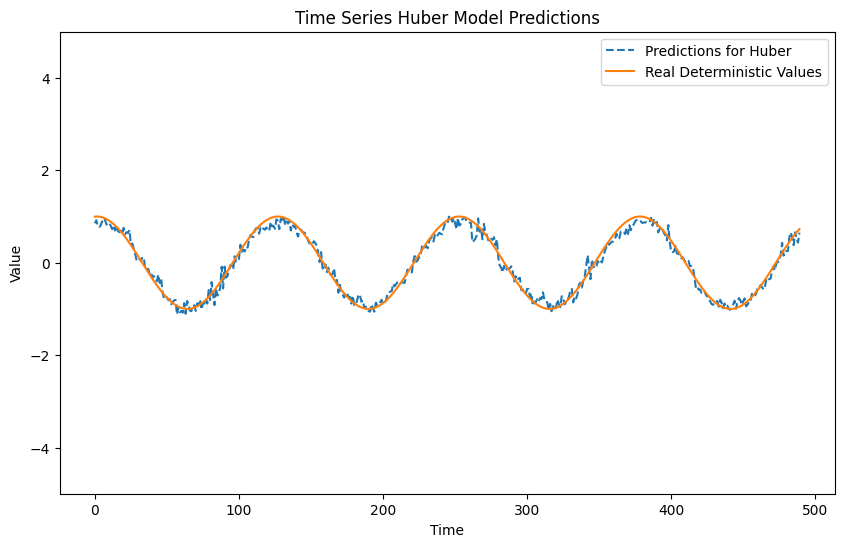

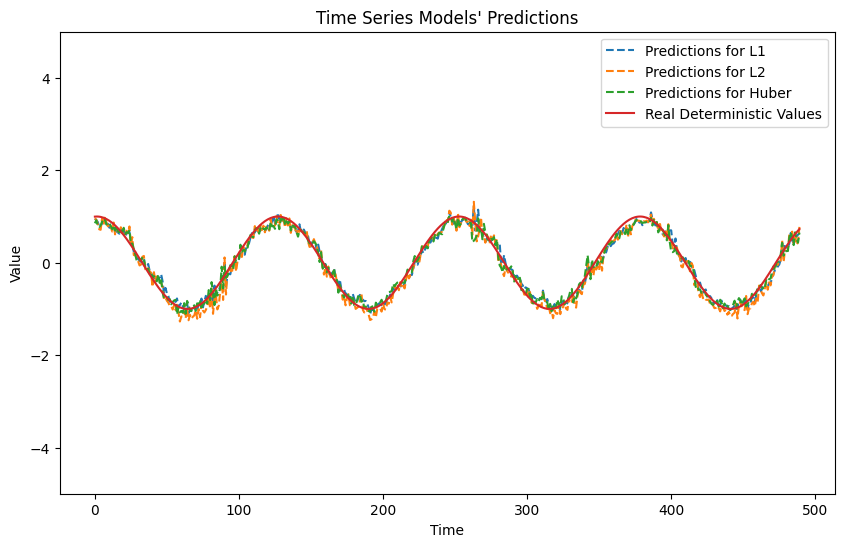

In [24]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: -0.007775811986139154 vs. Theoretical Mean: 0.5833333333333334
Median: -0.06091583133262729 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.31063385074653327 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.960346650151615
Kurtosis: 47.64387074752197
Max: 3.7784762786288546
Min: -0.5887157792345002




c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\src\Probability\classes.py:247: RuntimeWarning: invalid value encountered in power
  pdf_values = np.where(x >= xm, (alpha * xm**alpha) / (x**(alpha + 1)), 0)


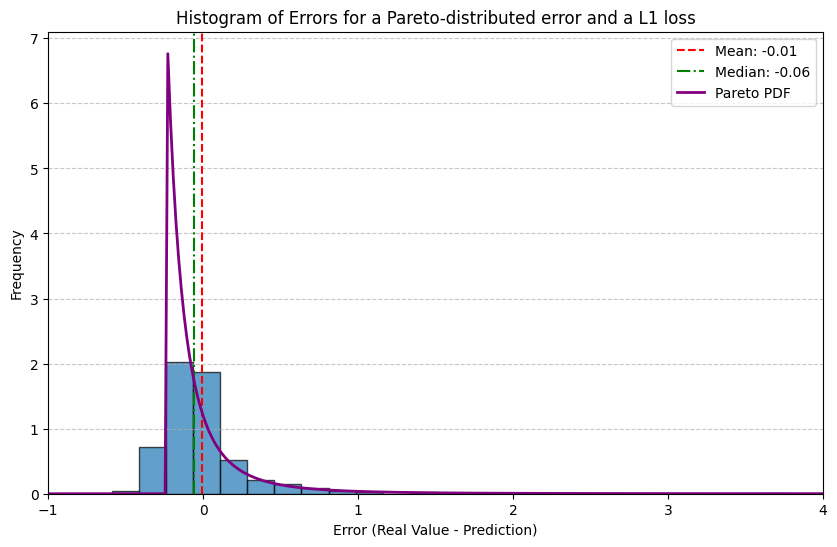

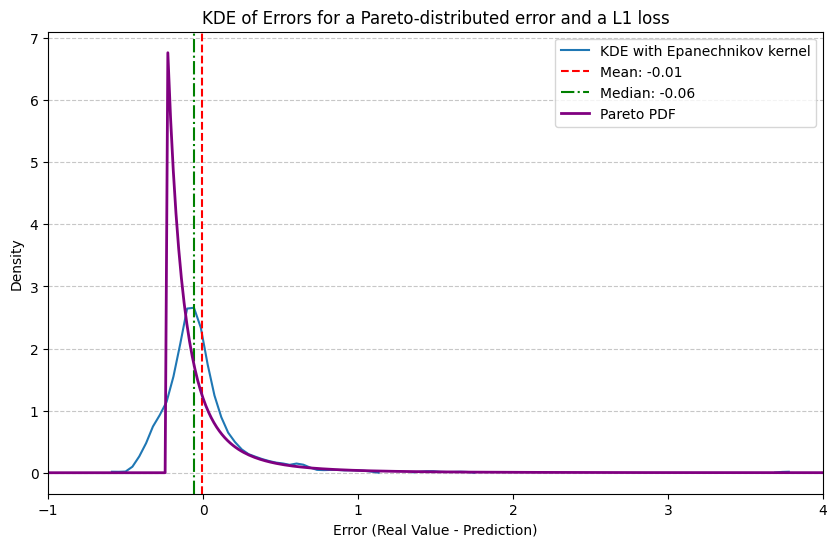

Analyzing errors for L2 loss...

Mean: 0.04521517847464938 vs. Theoretical Mean: 0.5833333333333334
Median: 0.001568952769305132 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29358311141585897 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 4.816344746254932
Kurtosis: 47.97251488130122
Max: 3.6464586065669344
Min: -0.47321993673254903




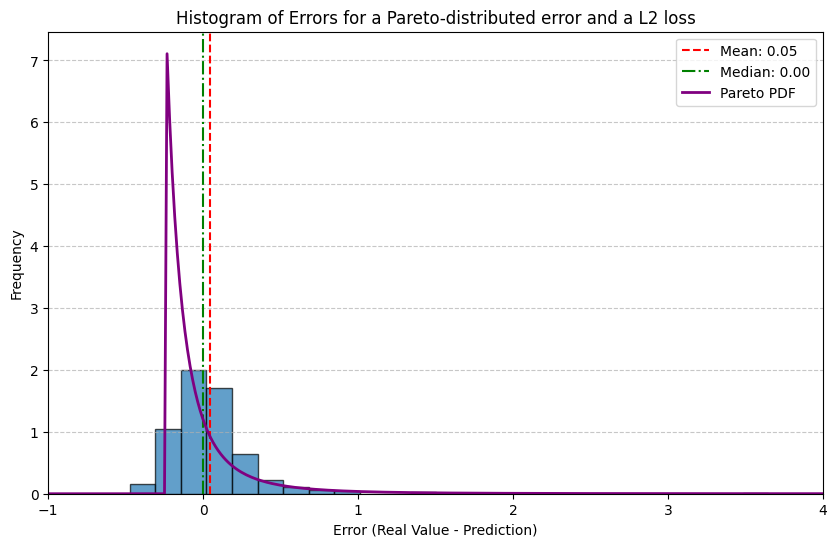

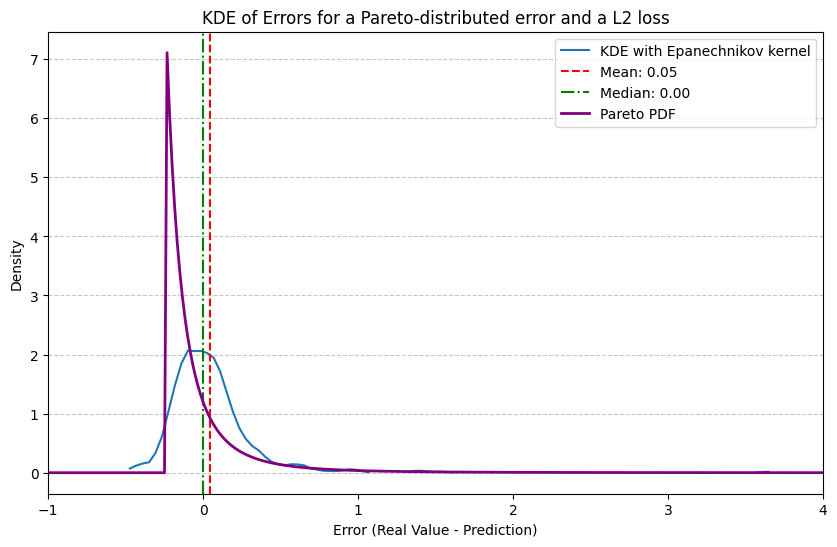

Analyzing errors for Huber loss...

Mean: -0.0002705575673076472 vs. Theoretical Mean: 0.5833333333333334
Median: -0.04720144722726527 vs. Theoretical Median: 0.46182776877051296
Standard Dev.: 0.29400740650602464 vs. Theoretical Std. Dev.: 0.5217491947499509
Skew: 5.286491832810582
Kurtosis: 54.213606519450785
Max: 3.716191868629007
Min: -0.49443336074504407




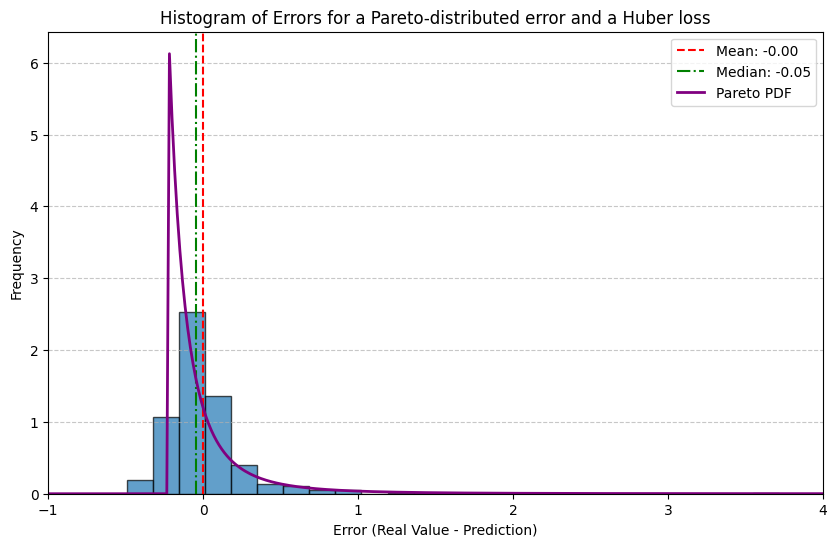

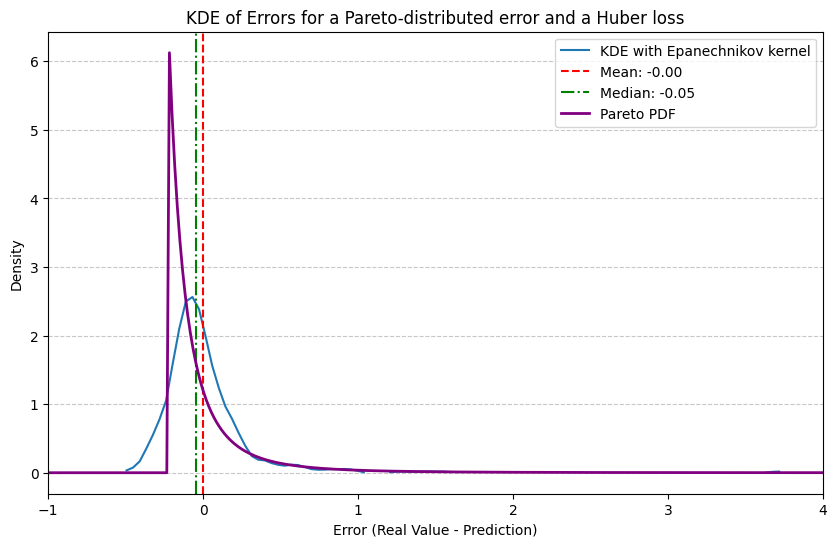

In [30]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=pareto)
    plot_hist.get_plot(loss_name=loss,x_limits=[-1,4])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=pareto,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-1,4])